## This notebook contains the best results (using PolynomialFeatures to generate all 2nd order and interaction terms, using Lasso to reduce that down to 58 variables (from 253), and log-transforming the target)

#### Note that Pools was dropped (highly colinear with Garage)

#### Also, the 18 zipcodes were collapsed down into the 13 communities (cities) they represent to eliminate unusually high VIFs amongst the original zipcode one-hots

In [519]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

import xgboost

In [520]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1) Read in data & explore preliminarily

In [521]:
df = pd.read_csv('home_sales_dataset.csv')
print(df.shape)
df.head()

(1011, 18)


sold_price  beds  baths  hm_sqft  lot_size  yr_built  zipcode  pool  \
0      970000     4    3.0     1933      6999      1960    91364     1   
1      900000     3    2.0     1519     11761      1974    91304     1   
2      830000     3    2.0     1595     10560      1960    91303     1   
3      820000     3    2.5     1364      7253      1959    91307     0   
4      940553     4    2.5     2018      9347      1960    91367     1   

   garage  stories  schools       sold_date             address  days_on_mkt  \
0       1        1      6.4  August-24-2021  22247 De La Osa St            3   
1       1        1      6.4  August-24-2021      7631 Atron Ave            3   
2       1        1      4.8  August-23-2021    22221 Vanowen St            4   
3       0        1      7.0  August-23-2021  23433 Victory Blvd            4   
4       1        1      6.8  August-23-2021     23952 Oxnard St            4   

   hoa                                                url        lat  \
0    0  http://www.redfin.com/CA/Woodland-Hills/22247-...  34.159168   
1    0  http://www.redfin.com/CA/Canoga-Park/7631-Atro...  34.209223   
2    0  http://www.redfin.com/CA/Canoga-Park/22221-Van...  34.193982   
3    0  http://www.redfin.com/CA/West-Hills/23433-Vict...  34.186740   
4    0  http://www.redfin.com/CA/Woodland-Hills/23952-...  34.179507   

          lon  
0 -118.611596  
1 -118.637737  
2 -118.611141  
3 -118.637805  
4 -118.649017

In [522]:
df['sold_date'] = pd.to_datetime(df['sold_date'])

In [523]:
df.head()

sold_price  beds  baths  hm_sqft  lot_size  yr_built  zipcode  pool  \
0      970000     4    3.0     1933      6999      1960    91364     1   
1      900000     3    2.0     1519     11761      1974    91304     1   
2      830000     3    2.0     1595     10560      1960    91303     1   
3      820000     3    2.5     1364      7253      1959    91307     0   
4      940553     4    2.5     2018      9347      1960    91367     1   

   garage  stories  schools  sold_date             address  days_on_mkt  hoa  \
0       1        1      6.4 2021-08-24  22247 De La Osa St            3    0   
1       1        1      6.4 2021-08-24      7631 Atron Ave            3    0   
2       1        1      4.8 2021-08-23    22221 Vanowen St            4    0   
3       0        1      7.0 2021-08-23  23433 Victory Blvd            4    0   
4       1        1      6.8 2021-08-23     23952 Oxnard St            4    0   

                                                 url        lat         lon  
0  http://www.redfin.com/CA/Woodland-Hills/22247-...  34.159168 -118.611596  
1  http://www.redfin.com/CA/Canoga-Park/7631-Atro...  34.209223 -118.637737  
2  http://www.redfin.com/CA/Canoga-Park/22221-Van...  34.193982 -118.611141  
3  http://www.redfin.com/CA/West-Hills/23433-Vict...  34.186740 -118.637805  
4  http://www.redfin.com/CA/Woodland-Hills/23952-...  34.179507 -118.649017

In [524]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sold_price   1011 non-null   int64         
 1   beds         1011 non-null   int64         
 2   baths        1011 non-null   float64       
 3   hm_sqft      1011 non-null   int64         
 4   lot_size     1011 non-null   int64         
 5   yr_built     1011 non-null   int64         
 6   zipcode      1011 non-null   int64         
 7   pool         1011 non-null   int64         
 8   garage       1011 non-null   int64         
 9   stories      1011 non-null   int64         
 10  schools      1011 non-null   float64       
 11  sold_date    1011 non-null   datetime64[ns]
 12  address      1011 non-null   object        
 13  days_on_mkt  1011 non-null   int64         
 14  hoa          1011 non-null   int64         
 15  url          1011 non-null   object        
 16  lat   

In [525]:
df.drop(columns=['zipcode', 'lat', 'lon']).describe()

sold_price         beds        baths      hm_sqft       lot_size  \
count  1.011000e+03  1011.000000  1011.000000  1011.000000    1011.000000   
mean   1.126206e+06     3.633037     2.544510  2081.720079   10828.724036   
std    5.022851e+05     0.844819     0.924634   886.574023   15533.545033   
min    4.000000e+05     1.000000     1.000000   552.000000    2000.000000   
25%    8.400000e+05     3.000000     2.000000  1471.000000    7083.000000   
50%    9.650000e+05     4.000000     2.000000  1873.000000    8217.000000   
75%    1.260000e+06     4.000000     3.000000  2447.000000   11761.000000   
max    5.500000e+06     8.000000     8.000000  8189.000000  475675.000000   

          yr_built         pool       garage      stories      schools  \
count  1011.000000  1011.000000  1011.000000  1011.000000  1011.000000   
mean   1960.297725     0.134520     0.140455     1.178042     5.738731   
std      11.616964     0.341379     0.347630     0.387876     0.674897   
min    1920.000000     0.000000     0.000000     1.000000     4.200000   
25%    1954.000000     0.000000     0.000000     1.000000     5.200000   
50%    1958.000000     0.000000     0.000000     1.000000     5.666667   
75%    1964.000000     0.000000     0.000000     1.000000     6.166667   
max    2021.000000     1.000000     1.000000     3.000000     7.666667   

       days_on_mkt          hoa  
count  1011.000000  1011.000000  
mean     44.678536     2.430267  
std      24.281487    24.731666  
min       1.000000     0.000000  
25%      25.000000     0.000000  
50%      44.000000     0.000000  
75%      64.000000     0.000000  
max      90.000000   585.000000

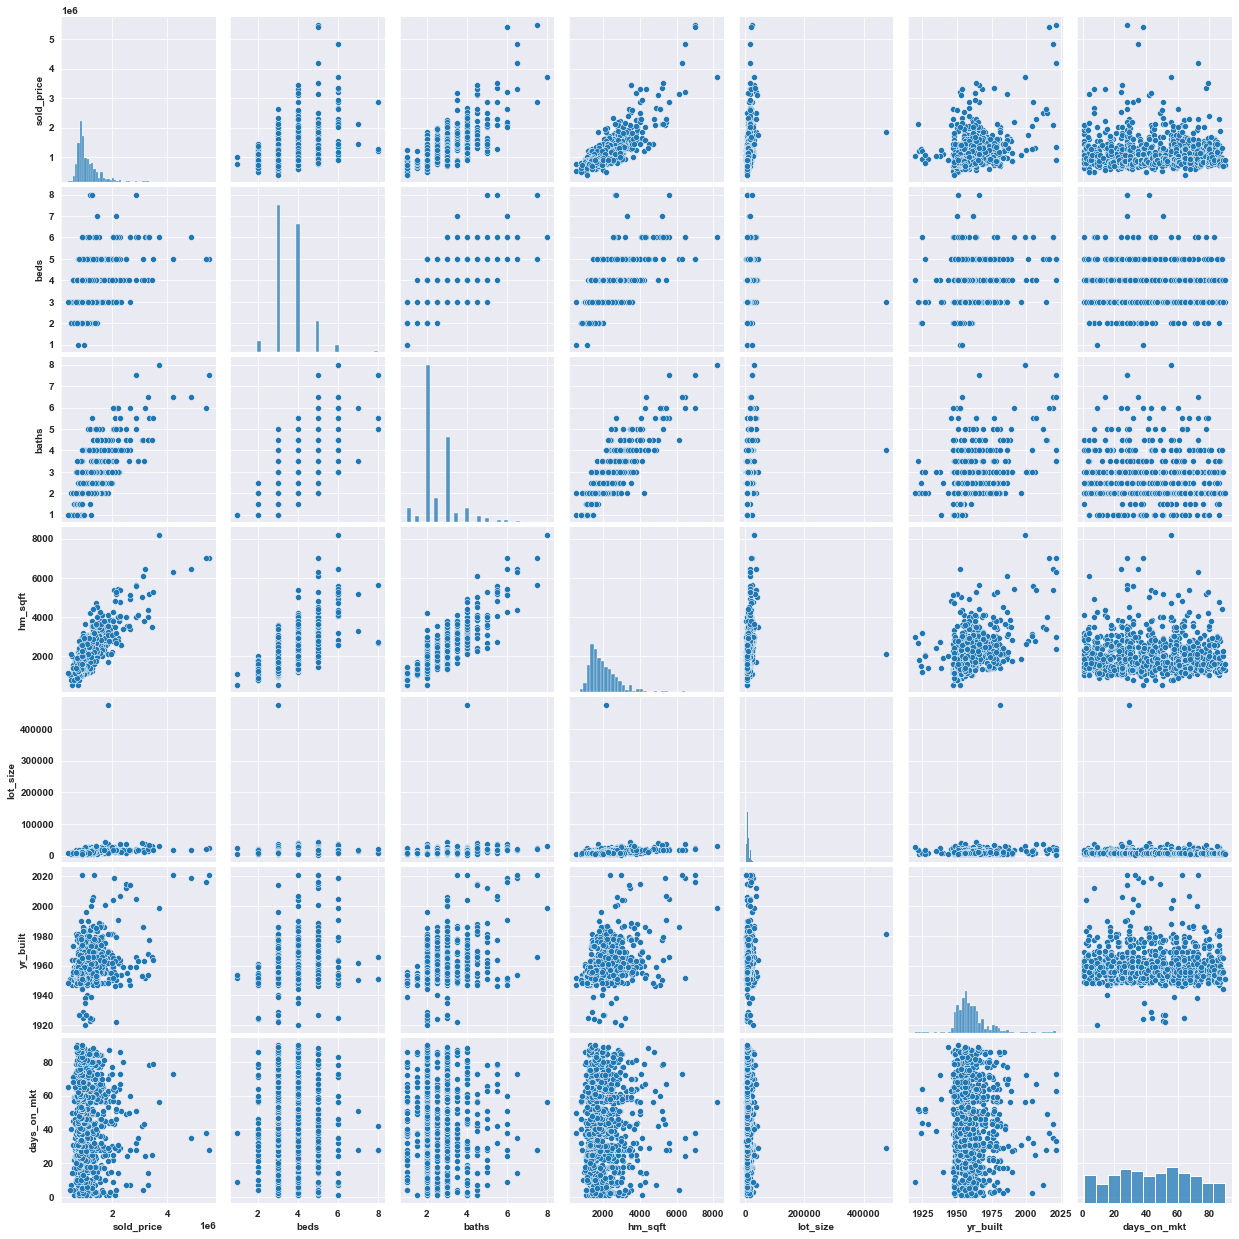

In [526]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']);

#### Drop that one home with a huge lot_size from the dataset (obvious undesirable outlier, not representative of vast majority)

In [527]:
print(df.shape)
df = df[df['lot_size'] < 200000]
df.reset_index(drop=True, inplace=True)
print(df.shape)

(1011, 18)
(1010, 18)


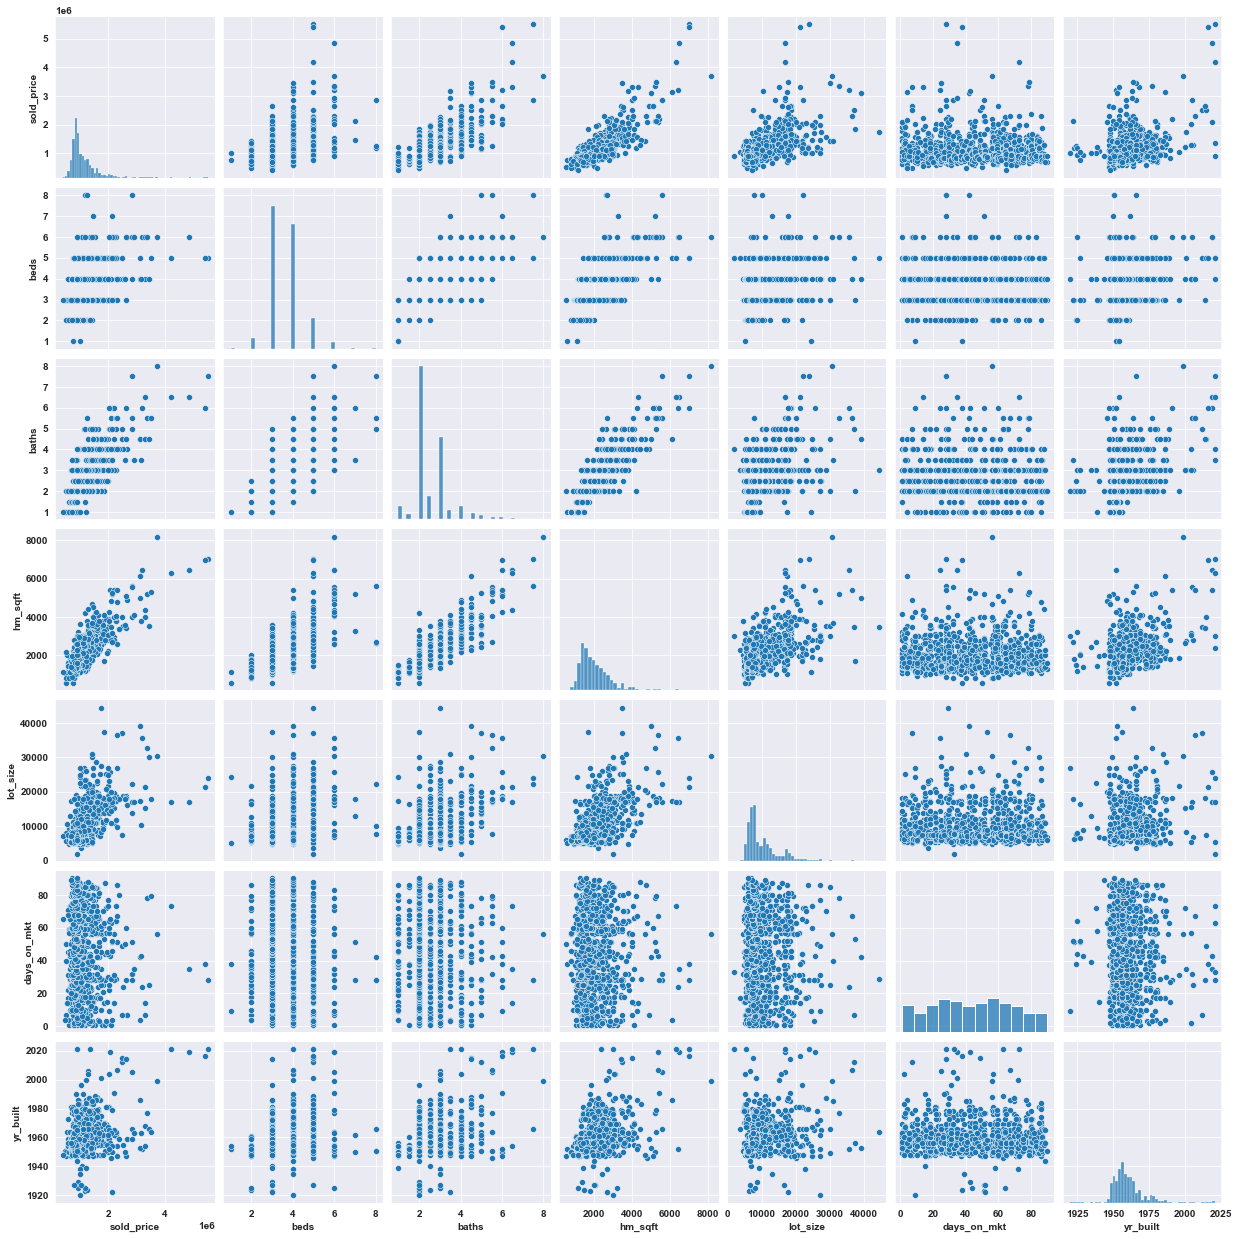

In [528]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'days_on_mkt', 'yr_built']);

In [529]:
df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']].corr()

sold_price      beds     baths   hm_sqft  lot_size  yr_built  \
sold_price     1.000000  0.468586  0.747992  0.836873  0.616309  0.405557   
beds           0.468586  1.000000  0.677780  0.673701  0.353676  0.330157   
baths          0.747992  0.677780  1.000000  0.853740  0.506800  0.425517   
hm_sqft        0.836873  0.673701  0.853740  1.000000  0.611860  0.482993   
lot_size       0.616309  0.353676  0.506800  0.611860  1.000000  0.235796   
yr_built       0.405557  0.330157  0.425517  0.482993  0.235796  1.000000   
days_on_mkt   -0.015035 -0.003969 -0.003983 -0.012386 -0.011387 -0.031676   

             days_on_mkt  
sold_price     -0.015035  
beds           -0.003969  
baths          -0.003983  
hm_sqft        -0.012386  
lot_size       -0.011387  
yr_built       -0.031676  
days_on_mkt     1.000000

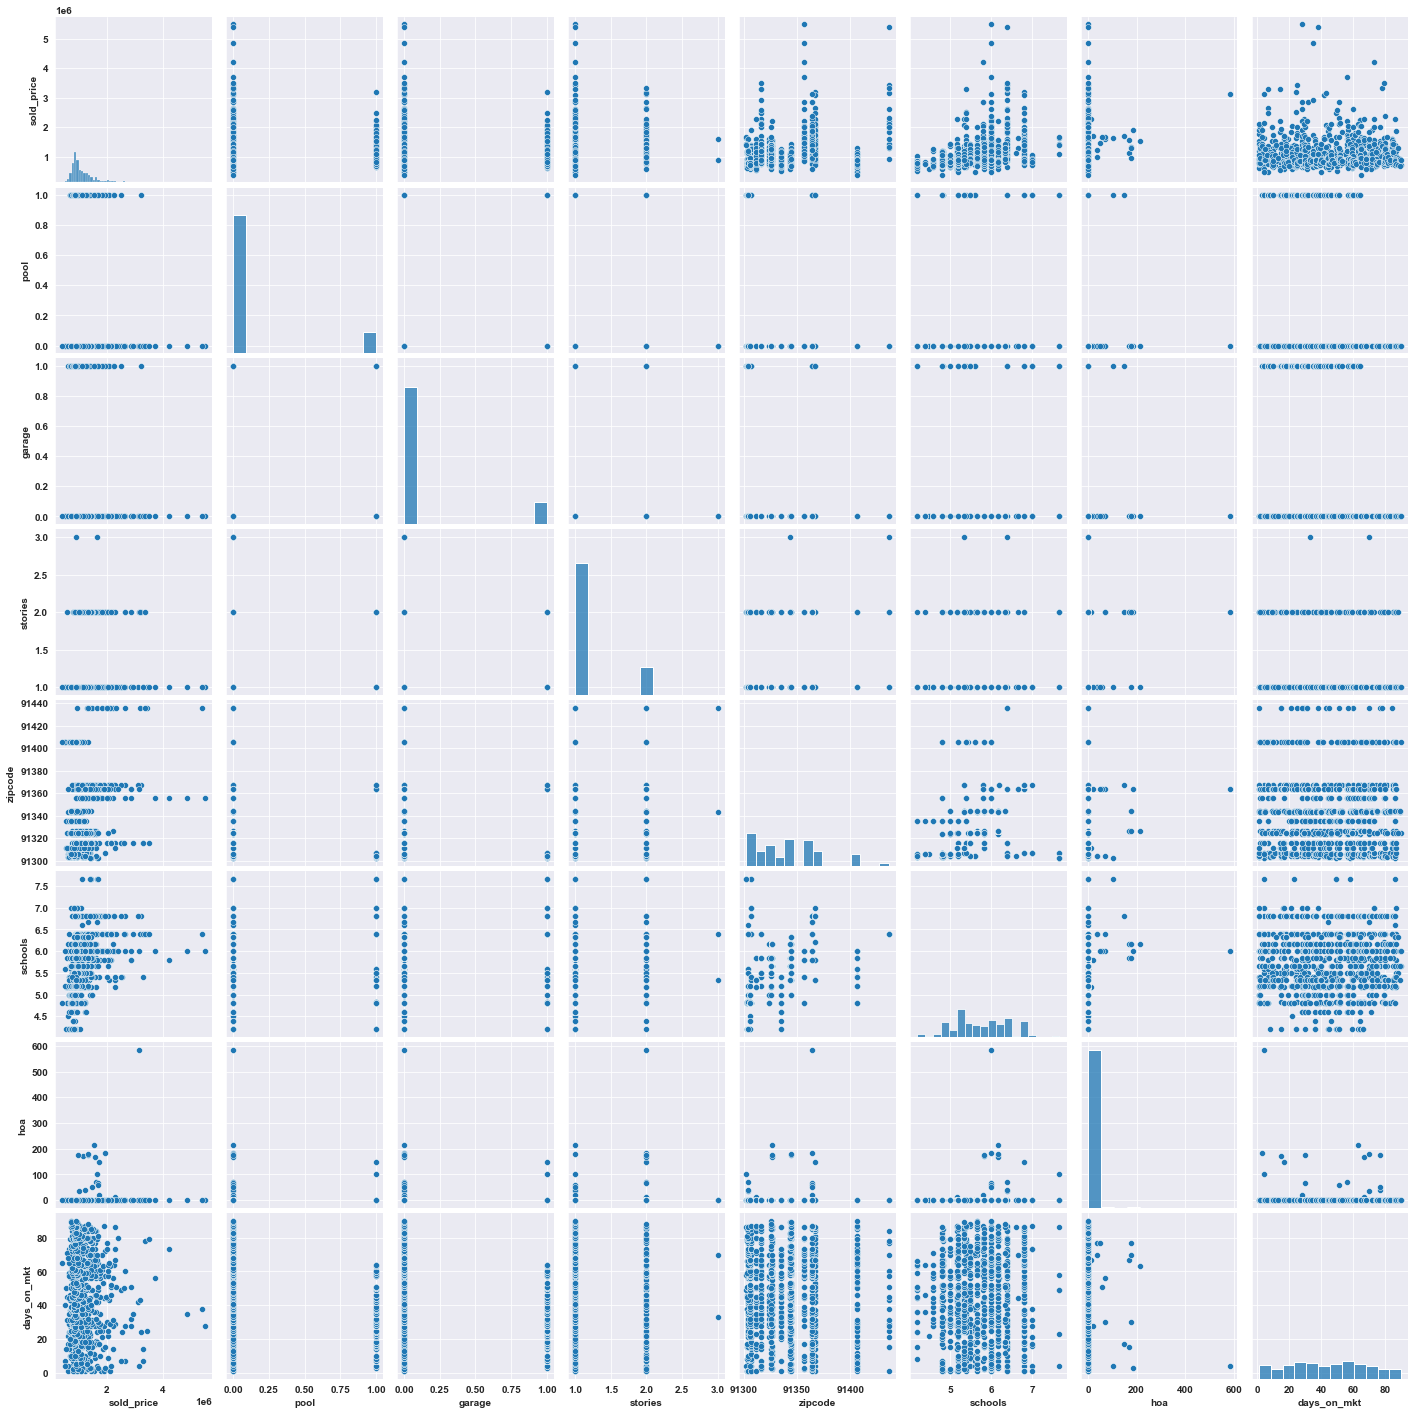

In [530]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']);

In [531]:
df[['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']].corr()

sold_price      pool    garage   stories   zipcode   schools  \
sold_price     1.000000  0.028298  0.025144  0.187080  0.219329  0.356463   
pool           0.028298  1.000000  0.950247  0.074175 -0.100235  0.268048   
garage         0.025144  0.950247  1.000000  0.057655 -0.096038  0.280840   
stories        0.187080  0.074175  0.057655  1.000000 -0.028739  0.177494   
zipcode        0.219329 -0.100235 -0.096038 -0.028739  1.000000  0.267983   
schools        0.356463  0.268048  0.280840  0.177494  0.267983  1.000000   
hoa            0.143552 -0.009247 -0.010762  0.136809  0.006319  0.061756   
days_on_mkt   -0.015035 -0.219170 -0.225222 -0.051873 -0.012574 -0.026134   

                  hoa  days_on_mkt  
sold_price   0.143552    -0.015035  
pool        -0.009247    -0.219170  
garage      -0.010762    -0.225222  
stories      0.136809    -0.051873  
zipcode      0.006319    -0.012574  
schools      0.061756    -0.026134  
hoa          1.000000    -0.042238  
days_on_mkt -0.042238     1.000000

#### Early conclusion: days_on_mkt (and alternative target) is uniformly distributed & pretty much uncorrelated w/ everything else!

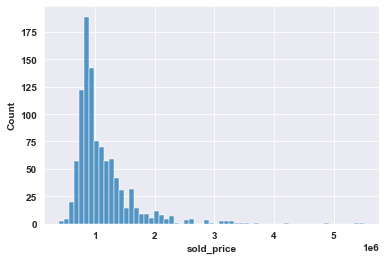

In [532]:
sns.histplot(data=df['sold_price']);

#### Perhaps log transforming the target can lead to a better model

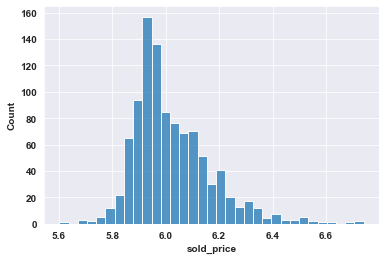

In [533]:
sns.histplot(data=np.log10(df['sold_price']));

# 2) Feature Engineering (part 1)

### Given the high VIFs with 1-hot zips, let's try grouping zipcodes into 'cities' and 1-hot that instead

In [534]:
df_data = df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 
              'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa']]

In [535]:
df_data['zipcode'].dtype

dtype('int64')

In [536]:
df_data['city'] = df_data['zipcode'].map({91302: 'woodland_hills',
                                          91303: 'canoga_park',
                                          91304: 'canoga_park',
                                          91306: 'winnetka',
                                          91307: 'west_hills',
                                          91311: 'chatsworth',
                                          91316: 'encino',
                                          91324: 'northridge',
                                          91325: 'northridge',
                                          91326: 'porter_ranch',
                                          91335: 'reseda',
                                          91343: 'north_hills',
                                          91344: 'granada_hills',
                                          91356: 'tarzana',
                                          91364: 'woodland_hills',
                                          91367: 'woodland_hills',
                                          91406: 'lake_balboa',
                                          91436: 'encino'}
                                        )

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/3655593410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['city'] = df_data['zipcode'].map({91302: 'woodland_hills',


In [537]:
df_data.drop(columns='zipcode')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sold_price  1010 non-null   int64  
 1   beds        1010 non-null   int64  
 2   baths       1010 non-null   float64
 3   hm_sqft     1010 non-null   int64  
 4   lot_size    1010 non-null   int64  
 5   yr_built    1010 non-null   int64  
 6   pool        1010 non-null   int64  
 7   garage      1010 non-null   int64  
 8   stories     1010 non-null   int64  
 9   zipcode     1010 non-null   int64  
 10  schools     1010 non-null   float64
 11  hoa         1010 non-null   int64  
 12  city        1010 non-null   object 
dtypes: float64(2), int64(10), object(1)
memory usage: 102.7+ KB


In [538]:
df_data = pd.get_dummies(df_data, columns=['city'], drop_first=True)
df_data.drop(columns='zipcode', inplace=True)

### Change 'stories' to binary variable 'one_story' (1 = yes, 0 = no => multi-story)

In [539]:
df_data['stories'].value_counts()

1    833
2    175
3      2
Name: stories, dtype: int64

In [540]:
df_data.loc[df_data['stories'] > 1, 'stories'] = 0
df_data.rename(columns={'stories': 'one_story'}, inplace=True)
df_data.head()

sold_price  beds  baths  hm_sqft  lot_size  yr_built  pool  garage  \
0      970000     4    3.0     1933      6999      1960     1       1   
1      900000     3    2.0     1519     11761      1974     1       1   
2      830000     3    2.0     1595     10560      1960     1       1   
3      820000     3    2.5     1364      7253      1959     0       0   
4      940553     4    2.5     2018      9347      1960     1       1   

   one_story  schools  hoa  city_chatsworth  city_encino  city_granada_hills  \
0          1      6.4    0                0            0                   0   
1          1      6.4    0                0            0                   0   
2          1      4.8    0                0            0                   0   
3          1      7.0    0                0            0                   0   
4          1      6.8    0                0            0                   0   

   city_lake_balboa  city_north_hills  city_northridge  city_porter_ranch  \
0                 0                 0                0                  0   
1                 0                 0                0                  0   
2                 0                 0                0                  0   
3                 0                 0                0                  0   
4                 0                 0                0                  0   

   city_reseda  city_tarzana  city_west_hills  city_winnetka  \
0            0             0                0              0   
1            0             0                0              0   
2            0             0                0              0   
3            0             0                1              0   
4            0             0                0              0   

   city_woodland_hills  
0                    1  
1                    0  
2                    0  
3                    0  
4                    1

In [541]:
df_data['one_story'].value_counts()

1    833
0    177
Name: one_story, dtype: int64

# 3) Baseline Features for Modeling

#### Define a Diagnostic Plot Function 
##### (adapted from func of same name provided in Metis linear assumptions & testing notebook)

In [542]:
def diagnostic_plots(x, y, y_pred):    
    
    plt.figure(figsize=(20,5))
    plt.tight_layout(pad=10.0)
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred,y)
    plt.plot([0, 3.5e6], [0, 3.5e6], color='r', linestyle='--')
    plt.title('Pred. vs. True Sale Price', fontweight='bold', size=18)
    plt.xlabel("Predicted", fontweight='bold', size=16)
    plt.ylabel("True Sale Price", fontweight='bold', size=16)
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.grid(True, linestyle='--')
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title("Residuals plot", fontweight='bold', size=18)
    plt.xlabel("Predicted", fontweight='bold', size=16)
    plt.ylabel("Residual", fontweight='bold', size=16)
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.grid(True, linestyle='--')
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot", fontweight='bold', size=18)
    plt.xlabel('Theoretical Quantiles', fontweight='bold', size=16)
    plt.ylabel('Ordered Values', fontweight='bold', size=16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.grid(True, linestyle='--')

In [543]:
def cv_rsquareds(x, y, model, cv):    
    scores = cross_val_score(model, x, y, scoring='r2', cv=cv)
    scores = [round(val, 3) for val in scores]
    
    print('CV R-squareds: {}'.format(scores)) 
    print('Mean CV R-squared: {} +/- {}'.format(round(np.mean(scores), 3), round(np.std(scores), 3)))
    
    n = x.shape[0]
    p = x.shape[1]
    adj_r_squareds = [round(1 - (1 - r_squared)*((n - 1)/(n - p - 1)), 3) for r_squared in scores]
    print('\nAdjusted CV R-squareds: {}'.format(adj_r_squareds))
    print('Mean Adjusted CV R-squared: {} +/- {}'.format(round(np.mean(adj_r_squareds), 3), 
                                                         round(np.std(adj_r_squareds), 3)))

In [544]:
# This function inverts the log transform on y_pred and y prior so that MAE can be computed in dollars

def mae_for_log_y(y, y_pred):
    return mean_absolute_error(10**y, 10**y_pred)

scorer = make_scorer(mae_for_log_y, greater_is_better=False)

In [545]:
def cv_maes(x, y, model, cv):
    scores = cross_val_score(model, x, y, scoring=scorer, cv=cv)
    scores = [round(val) for val in scores]
    
    print('\nCV MAEs: {}'.format([-1*score for score in scores])) 
    print('Mean CV MAE: {} +/- {}'.format(-1*round(np.mean(scores)), round(np.std(scores))))

In [546]:
# This function inverts the log transform on y_pred and y prior so that RMSE can be computed in dollars

def rmse_for_log_y(y, y_pred):
    return np.sqrt(mean_squared_error(10**y, 10**y_pred))

scorer2 = make_scorer(rmse_for_log_y, greater_is_better=False)

In [547]:
def cv_rmse(x, y, model, cv):
    scores = cross_val_score(model, x, y, scoring=scorer2, cv=cv)
    scores = [round(val) for val in scores]
    
    print('\nCV RMSEs: {}'.format([-1*score for score in scores])) 
    print('Mean CV RMSE: {} +/- {}'.format(-1*round(np.mean(scores)), round(np.std(scores))))

### Split into CV and Test Sets (will NOT touch Test set until final model has been chosen and tuned!)

In [548]:
X = df_data.drop(columns='sold_price')
y = np.log10(df_data['sold_price'])

In [549]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline Model 1: Linear Model, all features

In [550]:
model_1 = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1, 5)
cv_maes(X_cv, y_cv, model_1, 5)
cv_rmse(X_cv, y_cv, model_1, 5)

CV R-squareds: [0.822, 0.832, 0.836, 0.854, 0.842]
Mean CV R-squared: 0.837 +/- 0.011

Adjusted CV R-squareds: [0.817, 0.827, 0.831, 0.85, 0.838]
Mean Adjusted CV R-squared: 0.833 +/- 0.011

CV MAEs: [155512, 118132, 116949, 121273, 114859]
Mean CV MAE: 125345 +/- 15226

CV RMSEs: [336485, 184049, 164552, 183260, 155433]
Mean CV RMSE: 204756 +/- 66772


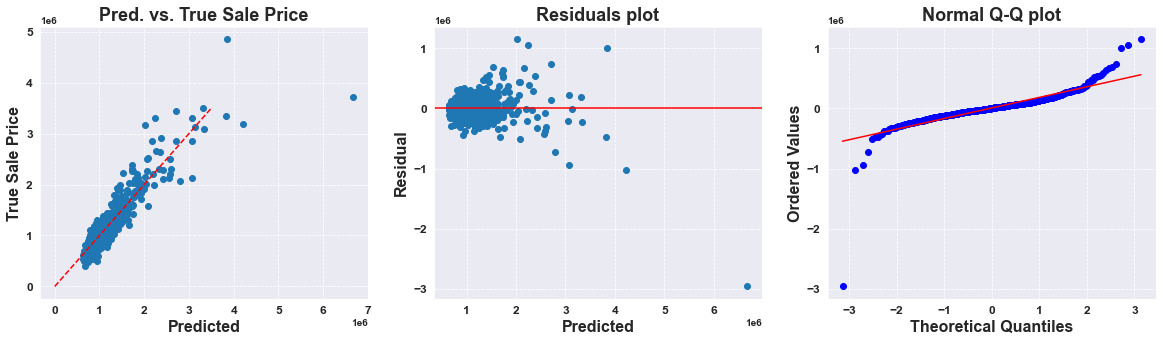

In [551]:
model_1.fit(X_cv, y_cv)

y_pred = model_1.predict(X_cv)

diagnostic_plots(X_cv, 10**y_cv, 10**y_pred)

#### Are the two highest priced predictions  influential points? Let's refit this using statsmodels to find out:

In [552]:
x_cv = sm.add_constant(X_cv)
model = sm.OLS(y_cv, x_cv)
model_1b = model.fit()
model_1b.summary()

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sold_price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     198.3
Date:                Mon, 13 Sep 2021   Prob (F-statistic):          1.49e-302
Time:                        19:33:26   Log-Likelihood:                 1161.0
No. Observations:                 808   AIC:                            -2276.
Df Residuals:                     785   BIC:                            -2168.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.1318      0.435     11.809      0.000       4.279       5.985
beds                   -0.0024      0.004     -0.640      0.522      -0.010       0.005
baths                   0.0239      0.005      5.277      0.000       0.015       0.033
hm_sqft              7.617e-05    5.4e-06     14.099      0.000    6.56e-05    8.68e-05
lot_size             5.671e-06    5.3e-07     10.707      0.000    4.63e-06    6.71e-06
yr_built                0.0002      0.000      0.889      0.374      -0.000       0.001
pool                   -0.0045      0.020     -0.222      0.825      -0.044       0.035
garage                  0.0006      0.020      0.032      0.975      -0.039       0.040
one_story               0.0149      0.006      2.387      0.017       0.003       0.027
schools                 0.0364      0.005      7.537      0.000       0.027       0.046
hoa                  8.908e-05   7.79e-05      1.143      0.253   -6.39e-05       0.000
city_chatsworth        -0.0451      0.013     -3.492      0.001      -0.070      -0.020
city_encino             0.1261      0.012     10.783      0.000       0.103       0.149
city_granada_hills     -0.0249      0.010     -2.462      0.014      -0.045      -0.005
city_lake_balboa       -0.0176      0.011     -1.641      0.101      -0.039       0.003
city_north_hills       -0.0386      0.011     -3.378      0.001      -0.061      -0.016
city_northridge        -0.0137      0.011     -1.238      0.216      -0.036       0.008
city_porter_ranch      -0.0019      0.012     -0.158      0.875      -0.026       0.022
city_reseda             0.0004      0.011      0.038      0.969      -0.022       0.023
city_tarzana            0.0877      0.013      6.592      0.000       0.062       0.114
city_west_hills        -0.0240      0.012     -2.063      0.039      -0.047      -0.001
city_winnetka          -0.0230      0.013     -1.710      0.088      -0.049       0.003
city_woodland_hills     0.0378      0.010      3.688      0.000       0.018       0.058
==============================================================================
Omnibus:                       55.160   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.868
Skew:                          -0.428   Prob(JB):                     3.10e-25
Kurtosis:                       4.619   Cond. No.                     2.54e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [553]:
influence_frame = model_1b.get_influence().summary_frame()
influence_frame['cooks_d'].sort_values(ascending=False).head()

499    0.123343
743    0.020294
129    0.019623
587    0.018494
695    0.017898
Name: cooks_d, dtype: float64

##### Interesting: Some of these largest Cook's distances (while definitely < 5) are for extremely high or low priced properties

In [554]:
print(10**y_cv.loc[499])
print(10**y_cv.loc[743])
print(10**y_cv.loc[129])
print(10**y_cv.loc[587])
print(10**y_cv.loc[695])

3710000.000000002
499000.0000000003
2074999.9999999986
545000.0000000001
3161999.9999999995


In [555]:
df_data['sold_price'].describe()

count    1.010000e+03
mean     1.125490e+06
std      5.020166e+05
min      4.000000e+05
25%      8.400000e+05
50%      9.650000e+05
75%      1.260000e+06
max      5.500000e+06
Name: sold_price, dtype: float64

In [556]:
df[df_data['sold_price'] < 575000].shape[0]

6

In [557]:
df_data[df_data['sold_price'] >= 3e6].shape[0]

14

In [558]:
df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]['sold_price'].describe()

count    9.900000e+02
mean     1.091561e+06
std      3.782013e+05
min      5.750000e+05
25%      8.400000e+05
50%      9.600000e+05
75%      1.250000e+06
max      2.919500e+06
Name: sold_price, dtype: float64

##### Command decision: 'sold_price' >= 3 million is almost 4-sigma from the mean, so let's just drop the 14 >= 3 million dollar homes
##### AND, 'sold_price" < 575k is even further from the mean than that, so let's also drop the 6 < 575k dollar homes
##### (i.e. This model is geared towards the much more common lower home prices, not the handful of very high-priced homes, and it's also
#####  geared toward those that have a "realistic" lower bound on prices - e.g., not something that's a teardown, former meth house, etc.)

#### While we're here, what about colinearity (VIF)?

In [559]:
variables = model_1b.model.exog

# Don't count the intercept! (index=0)
vifs = [variance_inflation_factor(variables, i) for i in range(1, variables.shape[1])]
list(zip(X_cv.columns, vifs))

[('beds', 2.3148128749207326),
 ('baths', 4.043471517332343),
 ('hm_sqft', 5.388832661032012),
 ('lot_size', 1.804812618293314),
 ('yr_built', 1.5541937438842295),
 ('pool', 11.55709054017307),
 ('garage', 11.693702898655935),
 ('one_story', 1.343850740615704),
 ('schools', 2.510301883327543),
 ('hoa', 1.0934388039308098),
 ('city_chatsworth', 1.4612584697994708),
 ('city_encino', 2.1620786184485126),
 ('city_granada_hills', 2.3727980763444694),
 ('city_lake_balboa', 1.9428917929050251),
 ('city_north_hills', 1.7670036533211684),
 ('city_northridge', 1.8548367675667148),
 ('city_porter_ranch', 2.009986217982023),
 ('city_reseda', 1.692616002511555),
 ('city_tarzana', 1.645057586080708),
 ('city_west_hills', 1.9691722555592364),
 ('city_winnetka', 1.3905932150645586),
 ('city_woodland_hills', 4.226194025443885)]

In [565]:
VIF_df = pd.DataFrame(data=list(zip(X_cv.columns, vifs)), columns=['Variable', 'VIF'])
VIF_df[10:16]

Variable       VIF
10     city_chatsworth  1.461258
11         city_encino  2.162079
12  city_granada_hills  2.372798
13    city_lake_balboa  1.942892
14    city_north_hills  1.767004
15     city_northridge  1.854837

In [566]:
VIF_df[16:]

Variable       VIF
16    city_porter_ranch  2.009986
17          city_reseda  1.692616
18         city_tarzana  1.645058
19      city_west_hills  1.969172
20        city_winnetka  1.390593
21  city_woodland_hills  4.226194

#### Note that the previous VIFs for the 'zipcode' 1-hots were way worse than these for the 'city' 1-hots!

In [389]:
df_data[['pool', 'garage']].corr()

pool    garage
pool    1.000000  0.950247
garage  0.950247  1.000000

In [390]:
df_data[['pool', 'garage']].value_counts()

pool  garage
0     0         865
1     1         133
0     1           9
1     0           3
dtype: int64

#### Aha! 'pool' & 'garage' are highly correlated (missed that in the pair plots); let's drop 'pool'

In [391]:
df_data = df_data.drop(columns='pool')

In [393]:
df_data.columns

Index(['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built',
       'garage', 'one_story', 'schools', 'hoa', 'city_chatsworth',
       'city_encino', 'city_granada_hills', 'city_lake_balboa',
       'city_north_hills', 'city_northridge', 'city_porter_ranch',
       'city_reseda', 'city_tarzana', 'city_west_hills', 'city_winnetka',
       'city_woodland_hills'],
      dtype='object')

#### Pare down the dataset (dropping extreme low and extreme high prices) and rebuild the model

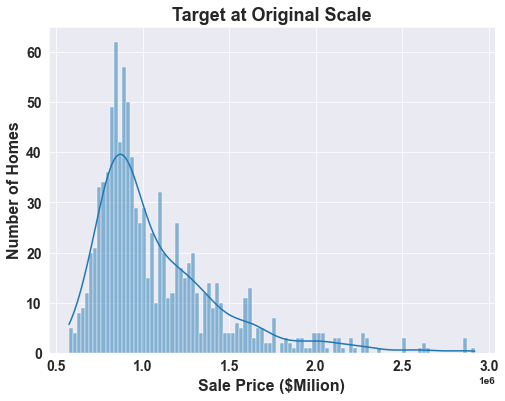

In [568]:
target = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]['sold_price']

sns.set_style("darkgrid")
plt.figure(figsize=(8,6))

sns.histplot(data=target, bins=100, kde=True)
plt.xlabel('Sale Price ($Milion)', size=16, fontweight='bold')
plt.ylabel('Number of Homes', size=16, fontweight='bold')
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Target at Original Scale', size=18, fontweight='bold')
del target;

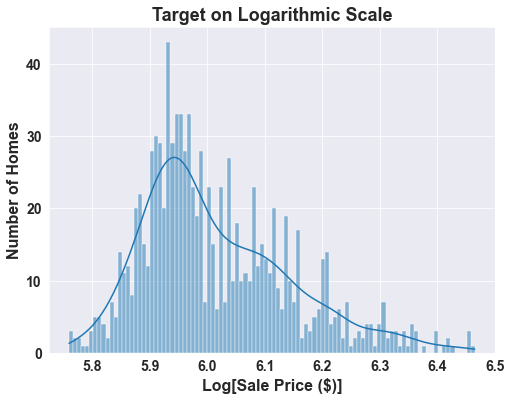

In [571]:
log_target = np.log10(df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]['sold_price'])

sns.set_style("darkgrid")
plt.figure(figsize=(8,6))

sns.histplot(data=log_target, bins=100, kde=True)
plt.xlabel('Log[Sale Price ($)]', size=16, fontweight='bold')
plt.ylabel('Number of Homes', size=16, fontweight='bold')
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Target on Logarithmic Scale', size=18, fontweight='bold')
del log_target;

In [394]:
X = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')
y = np.log10(df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]['sold_price'])

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [395]:
model_1c = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1c, 5)
cv_maes(X_cv, y_cv, model_1c, 5)
cv_rmse(X_cv, y_cv, model_1c, 5)

CV R-squareds: [0.843, 0.848, 0.835, 0.799, 0.801]
Mean CV R-squared: 0.825 +/- 0.021

Adjusted CV R-squareds: [0.839, 0.844, 0.83, 0.794, 0.796]
Mean Adjusted CV R-squared: 0.821 +/- 0.021

CV MAEs: [107057, 103473, 109814, 113575, 121100]
Mean CV MAE: 111004 +/- 6037

CV RMSEs: [147616, 142156, 158249, 163262, 168627]
Mean CV RMSE: 155982 +/- 9790


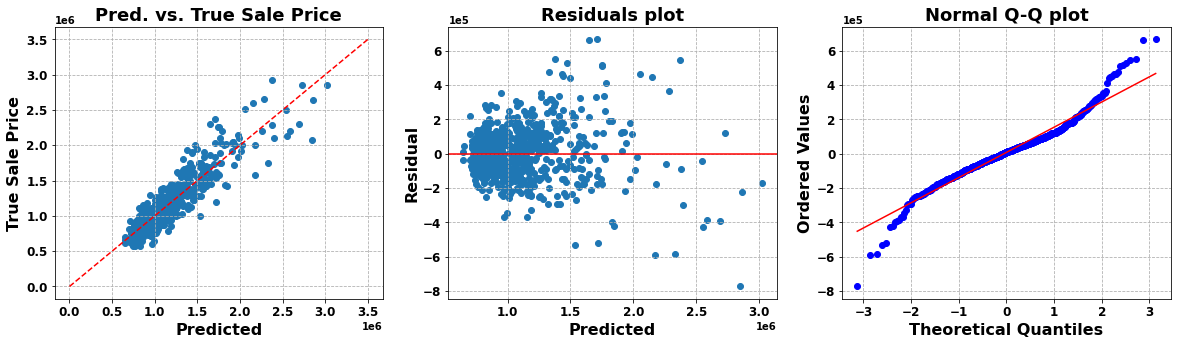

In [396]:
model_1c.fit(X_cv, y_cv)

y_pred = model_1c.predict(X_cv)

diagnostic_plots(X_cv, 10**y_cv, 10**y_pred)

### Model 2: Let's move to polynomial regression from here on

In [397]:
X2 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')

X2_cv, X2_test, y2_cv, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X2_cv = poly.fit_transform(X2_cv)

# Apply polynomial transformation to test set
X2_test = poly.transform(X2_test)

In [398]:
len(poly.get_feature_names())

253

In [399]:
model_2 = LinearRegression()

cv_rsquareds(X2_cv, y2_cv, model_2, 5)
cv_maes(X2_cv, y2_cv, model_2, 5)
cv_rmse(X2_cv, y2_cv, model_2, 5)

CV R-squareds: [0.133, -52.061, -9.554, 0.38, 0.737]
Mean CV R-squared: -12.073 +/- 20.364

Adjusted CV R-squareds: [-0.275, -77.013, -14.517, 0.088, 0.613]
Mean Adjusted CV R-squared: -18.221 +/- 29.941

CV MAEs: [135377, 93107517720521, 2445575182, 191043, 139965]
Mean CV MAE: 18621992752418 +/- 37242762496094

CV RMSEs: [223886, 1174028381253306, 30738272448, 279353, 236519]
Mean CV RMSE: 234811824053102 +/- 469608278750998


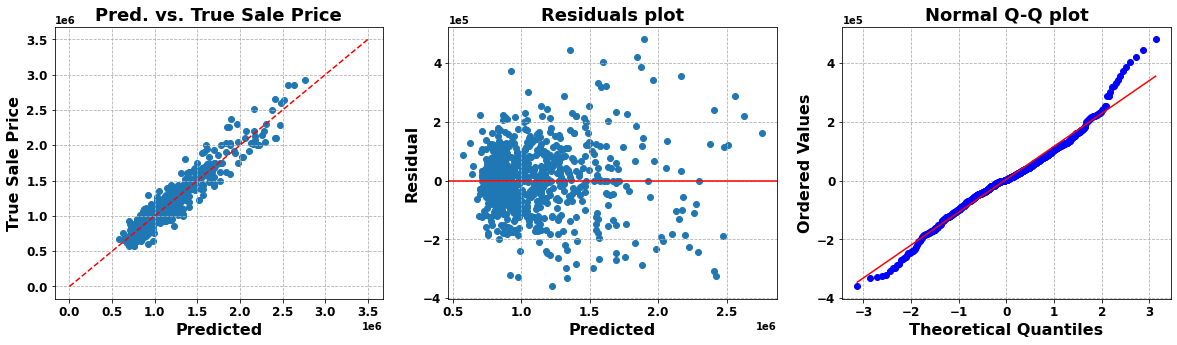

In [400]:
model_2.fit(X2_cv, y2_cv)

y2_pred = model_2.predict(X2_cv)

diagnostic_plots(X2_cv, 10**y2_cv, 10**y2_pred)

### Model 3: Try "Lazy" Lasso (specifically to eliminate some predictors)

In [401]:
X3 = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)].drop(columns='sold_price')

X3_cv, X3_test, y3_cv, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X3_cv = poly.fit_transform(X3_cv)

scaler = StandardScaler()
X3_cv_scaled = scaler.fit_transform(X3_cv)

In [402]:
alphas = 10**np.linspace(-5, -3, 1000)
lasso_model = LassoCV(alphas=alphas, cv=5, normalize=False, max_iter=100000)

lasso_model.fit(X3_cv_scaled, y3_cv)

alpha = round(lasso_model.alpha_, 4)
print('Best alpha: {}'.format(alpha))

Best alpha: 0.0003


In [403]:
model_3 = Lasso(alpha=0.0003, max_iter=100000)

cv_rsquareds(X3_cv_scaled, y3_cv, model_3, 5)
cv_maes(X3_cv_scaled, y3_cv, model_3, 5)
cv_rmse(X3_cv_scaled, y3_cv, model_3, 5)

CV R-squareds: [0.857, 0.868, 0.85, 0.805, 0.812]
Mean CV R-squared: 0.838 +/- 0.025

Adjusted CV R-squareds: [0.79, 0.806, 0.779, 0.713, 0.724]
Mean Adjusted CV R-squared: 0.762 +/- 0.037

CV MAEs: [98322, 96267, 99958, 108375, 116691]
Mean CV MAE: 103923 +/- 7597

CV RMSEs: [138182, 128666, 135218, 162921, 161511]
Mean CV RMSE: 145300 +/- 14158


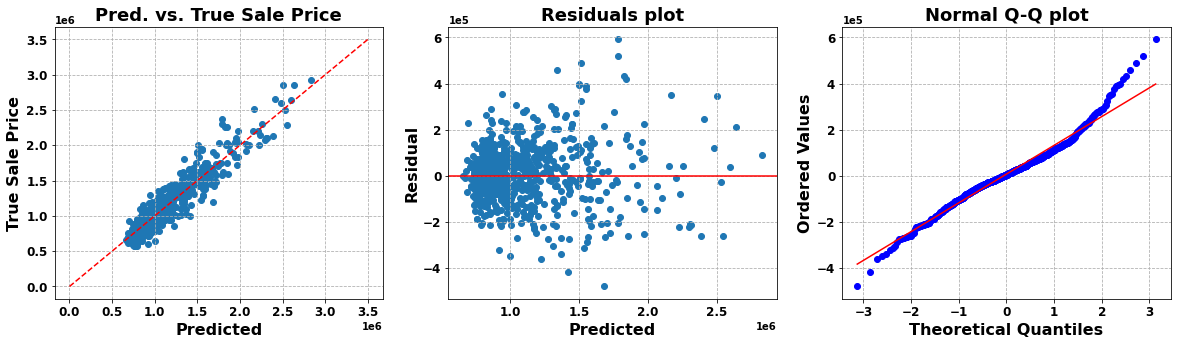

In [404]:
model_3.fit(X3_cv_scaled, y3_cv)

y3_pred = model_3.predict(X3_cv_scaled)

diagnostic_plots(X3_cv, 10**y3_cv, 10**y3_pred)

In [405]:
temp = [val for val in list(zip(poly.get_feature_names(), model_3.coef_)) if val[1] != 0.0]
temp

[('x2', 0.0021060403879509188),
 ('x3', 0.04779119622846495),
 ('x4', 0.002956616108090547),
 ('x7', -0.002435692399904054),
 ('x0^2', -0.0006625616917479133),
 ('x0 x12', 0.002585496690373786),
 ('x0 x13', -0.003110983162279282),
 ('x1 x4', 0.0006037043002631195),
 ('x1 x5', -0.0048015440962489156),
 ('x1 x6', 0.0018441719581410395),
 ('x1 x7', 0.014593087729821234),
 ('x1 x11', -0.00667958874834255),
 ('x1 x13', -0.0034024072281186577),
 ('x1 x15', 0.0031656428356155336),
 ('x1 x18', 0.007681874538882879),
 ('x2^2', -0.018831710811167687),
 ('x2 x4', 0.005584781986918696),
 ('x2 x7', 0.07614412774183231),
 ('x2 x9', 0.000913886890516638),
 ('x2 x10', 0.018138934731820856),
 ('x2 x13', -0.0016560487983098408),
 ('x2 x15', -0.007645243949810842),
 ('x2 x16', 0.013520790367330062),
 ('x2 x19', -0.0013993511600417599),
 ('x3^2', -0.03743180939981416),
 ('x3 x5', 0.0037768203642409653),
 ('x3 x6', 0.007560207115766725),
 ('x3 x9', 0.0016415694301989481),
 ('x3 x10', 0.0023233840527937992)

In [406]:
temp2 = [val[0].replace('x', '') for val in temp]

In [407]:
temp3 = [val.replace(' ', '*').replace('^', '**') for val in temp2]

In [408]:
results = []
for val in temp3:
    if '**' in val:
        results.append(X3.columns[int(val.split('**')[0])] + '_SQ')
    elif '*' in val:
        results.append(X3.columns[int(val.split('*')[0])] + '_X_' + X3.columns[int(val.split('*')[1])])
    else:
        results.append(X3.columns[int(val)])
results

['hm_sqft',
 'lot_size',
 'yr_built',
 'schools',
 'beds_SQ',
 'beds_X_city_lake_balboa',
 'beds_X_city_north_hills',
 'baths_X_yr_built',
 'baths_X_garage',
 'baths_X_one_story',
 'baths_X_schools',
 'baths_X_city_granada_hills',
 'baths_X_city_north_hills',
 'baths_X_city_porter_ranch',
 'baths_X_city_west_hills',
 'hm_sqft_SQ',
 'hm_sqft_X_yr_built',
 'hm_sqft_X_schools',
 'hm_sqft_X_city_chatsworth',
 'hm_sqft_X_city_encino',
 'hm_sqft_X_city_north_hills',
 'hm_sqft_X_city_porter_ranch',
 'hm_sqft_X_city_reseda',
 'hm_sqft_X_city_winnetka',
 'lot_size_SQ',
 'lot_size_X_garage',
 'lot_size_X_one_story',
 'lot_size_X_city_chatsworth',
 'lot_size_X_city_encino',
 'lot_size_X_city_granada_hills',
 'lot_size_X_city_north_hills',
 'lot_size_X_city_northridge',
 'lot_size_X_city_reseda',
 'lot_size_X_city_tarzana',
 'lot_size_X_city_woodland_hills',
 'yr_built_X_city_porter_ranch',
 'garage_X_one_story',
 'garage_X_hoa',
 'garage_X_city_west_hills',
 'one_story_X_schools',
 'one_story_X_h

#### Now re-run Lasso with just the terms (non-zero coefficients from first Lasso) above

In [409]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X3 = temp_df[['hm_sqft', 'lot_size', 'yr_built', 'schools']]
X3['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X3['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
X3['baths_X_yr_built'] = temp_df['baths'] * temp_df['yr_built']
X3['baths_X_garage'] = temp_df['baths'] * temp_df['garage']
X3['baths_X_one_story'] = temp_df['baths'] * temp_df['one_story']
X3['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X3['baths_X_city_granada_hills'] = temp_df['baths'] * temp_df['city_granada_hills']
X3['baths_X_city_north_hills'] = temp_df['baths'] * temp_df['city_north_hills']
X3['baths_X_city_porter_ranch'] = temp_df['baths'] * temp_df['city_porter_ranch']
X3['baths_X_city_west_hills'] = temp_df['baths'] * temp_df['city_west_hills']
X3['hm_sqft_X_yr_built'] = temp_df['hm_sqft'] * temp_df['yr_built']
X3['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X3['hm_sqft_X_city_chatsworth'] = temp_df['hm_sqft'] * temp_df['city_chatsworth']
X3['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X3['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X3['hm_sqft_X_city_porter_ranch'] = temp_df['hm_sqft'] * temp_df['city_porter_ranch']
X3['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X3['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X3['lot_size_X_garage'] = temp_df['lot_size'] * temp_df['garage']
X3['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X3['lot_size_X_city_chatsworth'] = temp_df['lot_size'] * temp_df['city_chatsworth']
X3['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X3['lot_size_X_city_granada_hills'] = temp_df['lot_size'] * temp_df['city_granada_hills']
X3['lot_size_X_city_north_hills'] = temp_df['lot_size'] * temp_df['city_north_hills']
X3['lot_size_X_city_northridge'] = temp_df['lot_size'] * temp_df['city_northridge']
X3['lot_size_X_city_reseda'] = temp_df['lot_size'] * temp_df['city_reseda']
X3['lot_size_X_city_tarzana'] = temp_df['lot_size'] * temp_df['city_tarzana']
X3['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X3['yr_built_X_city_porter_ranch',] = temp_df['yr_built'] * temp_df['city_porter_ranch']
X3['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X3['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X3['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X3['one_story_X_schools'] = temp_df['one_story'] * temp_df['schools']
X3['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X3['one_story_X_city_chatsworth'] = temp_df['one_story'] * temp_df['city_chatsworth']
X3['one_story_X_city_granada_hills'] = temp_df['one_story'] * temp_df['city_granada_hills']
X3['one_story_X_city_north_hills'] = temp_df['one_story'] * temp_df['city_north_hills']
X3['one_story_X_city_northridge'] = temp_df['one_story'] * temp_df['city_northridge']
X3['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X3['one_story_X_city_west_hills'] = temp_df['one_story'] * temp_df['city_west_hills']
X3['schools_X_city_chatsworth'] = temp_df['schools'] * temp_df['city_chatsworth']
X3['schools_X_city_encino'] = temp_df['schools'] * temp_df['city_encino']
X3['schools_X_city_northridge'] = temp_df['schools'] * temp_df['city_northridge']
X3['schools_X_city_reseda'] = temp_df['schools'] * temp_df['city_reseda']
X3['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X3['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X3['schools_X_city_winnetka'] = temp_df['schools'] * temp_df['city_winnetka']
X3['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X3['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X3['hoa_X_city_porter_ranch'] = temp_df['hoa'] * temp_df['city_porter_ranch']
X3['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X3['beds_SQ'] = temp_df['beds'] * temp_df['beds']
X3['hm_sqft_SQ'] = temp_df['hm_sqft'] * temp_df['hm_sqft']
X3['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/1263637275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/1263637275.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/1263637275.py:5: SettingWithCopyWar

In [410]:
X3_cv, X3_test, y3_cv, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X3_cv_scaled = scaler.fit_transform(X3_cv)

In [133]:
alphas = 10**np.linspace(-5, -3, 1000)
lasso_model = LassoCV(alphas=alphas, cv=5, normalize=False, max_iter=100000)

lasso_model.fit(X3_cv_scaled, y3_cv)

alpha = round(lasso_model.alpha_, 4)
print('Best alpha: {}'.format(alpha))

Best alpha: 0.0002


In [411]:
model_3 = Lasso(alpha=0.0002, max_iter=100000)

cv_rsquareds(X3_cv_scaled, y3_cv, model_3, 5)
cv_maes(X3_cv_scaled, y3_cv, model_3, 5)
cv_rmse(X3_cv_scaled, y3_cv, model_3, 5)

CV R-squareds: [0.862, 0.871, 0.854, 0.809, 0.828]
Mean CV R-squared: 0.845 +/- 0.023

Adjusted CV R-squareds: [0.851, 0.861, 0.842, 0.794, 0.814]
Mean Adjusted CV R-squared: 0.832 +/- 0.025

CV MAEs: [97555, 93611, 98572, 107001, 110481]
Mean CV MAE: 101444 +/- 6281

CV RMSEs: [135408, 125501, 132414, 160629, 151559]
Mean CV RMSE: 141102 +/- 12976


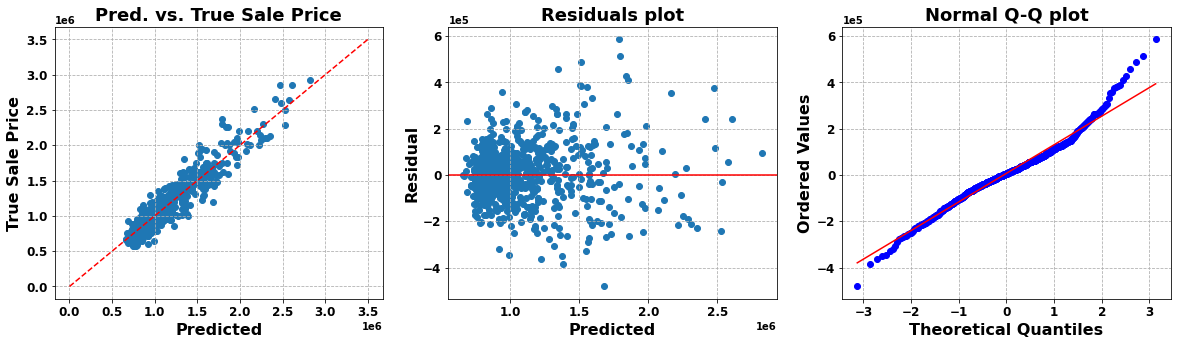

In [412]:
model_3.fit(X3_cv_scaled, y3_cv)

y3_pred = model_3.predict(X3_cv_scaled)

diagnostic_plots(X3_cv, 10**y3_cv, 10**y3_pred)

#### We can now take just terms above, manually form them into the data and rerun a normal linear reg (model 2)

### Model 2b: Unregularized Linear Regression Again (on just the Lasso-selected variables)

In [413]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X2b = temp_df[['hm_sqft', 'lot_size', 'yr_built', 'schools']]
X2b['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X2b['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
X2b['baths_X_yr_built'] = temp_df['baths'] * temp_df['yr_built']
X2b['baths_X_garage'] = temp_df['baths'] * temp_df['garage']
X2b['baths_X_one_story'] = temp_df['baths'] * temp_df['one_story']
X2b['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X2b['baths_X_city_granada_hills'] = temp_df['baths'] * temp_df['city_granada_hills']
X2b['baths_X_city_north_hills'] = temp_df['baths'] * temp_df['city_north_hills']
X2b['baths_X_city_porter_ranch'] = temp_df['baths'] * temp_df['city_porter_ranch']
X2b['baths_X_city_west_hills'] = temp_df['baths'] * temp_df['city_west_hills']
X2b['hm_sqft_X_yr_built'] = temp_df['hm_sqft'] * temp_df['yr_built']
X2b['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X2b['hm_sqft_X_city_chatsworth'] = temp_df['hm_sqft'] * temp_df['city_chatsworth']
X2b['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X2b['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X2b['hm_sqft_X_city_porter_ranch'] = temp_df['hm_sqft'] * temp_df['city_porter_ranch']
X2b['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X2b['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X2b['lot_size_X_garage'] = temp_df['lot_size'] * temp_df['garage']
X2b['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X2b['lot_size_X_city_chatsworth'] = temp_df['lot_size'] * temp_df['city_chatsworth']
X2b['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X2b['lot_size_X_city_granada_hills'] = temp_df['lot_size'] * temp_df['city_granada_hills']
X2b['lot_size_X_city_north_hills'] = temp_df['lot_size'] * temp_df['city_north_hills']
X2b['lot_size_X_city_northridge'] = temp_df['lot_size'] * temp_df['city_northridge']
X2b['lot_size_X_city_reseda'] = temp_df['lot_size'] * temp_df['city_reseda']
X2b['lot_size_X_city_tarzana'] = temp_df['lot_size'] * temp_df['city_tarzana']
X2b['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X2b['yr_built_X_city_porter_ranch',] = temp_df['yr_built'] * temp_df['city_porter_ranch']
X2b['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X2b['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X2b['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X2b['one_story_X_schools'] = temp_df['one_story'] * temp_df['schools']
X2b['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X2b['one_story_X_city_chatsworth'] = temp_df['one_story'] * temp_df['city_chatsworth']
X2b['one_story_X_city_granada_hills'] = temp_df['one_story'] * temp_df['city_granada_hills']
X2b['one_story_X_city_north_hills'] = temp_df['one_story'] * temp_df['city_north_hills']
X2b['one_story_X_city_northridge'] = temp_df['one_story'] * temp_df['city_northridge']
X2b['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X2b['one_story_X_city_west_hills'] = temp_df['one_story'] * temp_df['city_west_hills']
X2b['schools_X_city_chatsworth'] = temp_df['schools'] * temp_df['city_chatsworth']
X2b['schools_X_city_encino'] = temp_df['schools'] * temp_df['city_encino']
X2b['schools_X_city_northridge'] = temp_df['schools'] * temp_df['city_northridge']
X2b['schools_X_city_reseda'] = temp_df['schools'] * temp_df['city_reseda']
X2b['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X2b['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X2b['schools_X_city_winnetka'] = temp_df['schools'] * temp_df['city_winnetka']
X2b['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X2b['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X2b['hoa_X_city_porter_ranch'] = temp_df['hoa'] * temp_df['city_porter_ranch']
X2b['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X2b['beds_SQ'] = temp_df['beds'] * temp_df['beds']
X2b['hm_sqft_SQ'] = temp_df['hm_sqft'] * temp_df['hm_sqft']
X2b['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/1993825186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2b['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/1993825186.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2b['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/1993825186.py:5: SettingWithCopyW

In [414]:
X2b.head()

hm_sqft  lot_size  yr_built  schools  beds_X_city_lake_balboa  \
0     1933      6999      1960      6.4                        0   
1     1519     11761      1974      6.4                        0   
2     1595     10560      1960      4.8                        0   
3     1364      7253      1959      7.0                        0   
4     2018      9347      1960      6.8                        0   

   beds_X_city_north_hills  baths_X_yr_built  baths_X_garage  \
0                        0            5880.0             3.0   
1                        0            3948.0             2.0   
2                        0            3920.0             2.0   
3                        0            4897.5             0.0   
4                        0            4900.0             2.5   

   baths_X_one_story  baths_X_schools  baths_X_city_granada_hills  \
0                3.0             19.2                         0.0   
1                2.0             12.8                         0.0   
2                2.0              9.6                         0.0   
3                2.5             17.5                         0.0   
4                2.5             17.0                         0.0   

   baths_X_city_north_hills  baths_X_city_porter_ranch  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        0.0   

   baths_X_city_west_hills  hm_sqft_X_yr_built  hm_sqft_X_schools  \
0                      0.0             3788680            12371.2   
1                      0.0             2998506             9721.6   
2                      0.0             3126200             7656.0   
3                      2.5             2672076             9548.0   
4                      0.0             3955280            13722.4   

   hm_sqft_X_city_chatsworth  hm_sqft_X_city_encino  \
0                          0                      0   
1                          0                      0   
2                          0                      0   
3                          0                      0   
4                          0                      0   

   hm_sqft_X_city_north_hills  hm_sqft_X_city_porter_ranch  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   hm_sqft_X_city_reseda  hm_sqft_X_city_winnetka  lot_size_X_garage  \
0                      0                        0               6999   
1                      0                        0              11761   
2                      0                        0              10560   
3                      0                        0                  0   
4                      0                        0               9347   

   lot_size_X_one_story  lot_size_X_city_chatsworth  lot_size_X_city_encino  \
0                  6999                           0                       0   
1                 11761                           0                       0   
2                 10560                           0                       0   
3                  7253                           0                       0   
4                  9347                           0                       0   

   lot_size_X_city_granada_hills  lot_size_X_city_north_hills  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            0   

   lot_size_X_city_northrid

In [415]:
X2b_cv, X2b_test, y2b_cv, y2b_test = train_test_split(X2b, y, test_size=0.2, random_state=42)

In [416]:
model_2b = LinearRegression()

cv_rsquareds(X2b_cv, y2b_cv, model_2b, 5)
cv_maes(X2b_cv, y2b_cv, model_2b, 5)
cv_rmse(X2b_cv, y2b_cv, model_2b, 5)

CV R-squareds: [0.853, 0.867, 0.846, 0.805, 0.831]
Mean CV R-squared: 0.84 +/- 0.021

Adjusted CV R-squareds: [0.841, 0.856, 0.834, 0.79, 0.818]
Mean Adjusted CV R-squared: 0.828 +/- 0.023

CV MAEs: [101480, 95128, 103755, 107969, 110712]
Mean CV MAE: 103809 +/- 5399

CV RMSEs: [139842, 128129, 141538, 163171, 149950]
Mean CV RMSE: 144526 +/- 11634


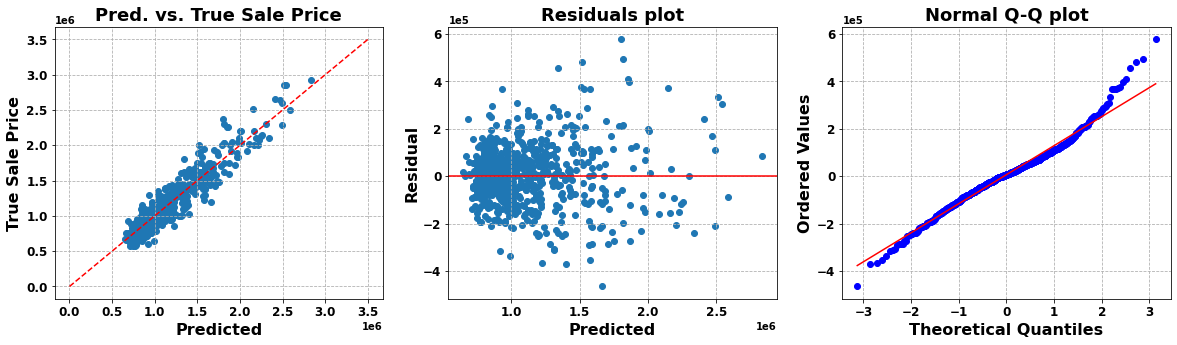

In [417]:
model_2b.fit(X2b_cv, y2b_cv)

y2b_pred = model_2b.predict(X2b_cv)

diagnostic_plots(X2b_cv, 10**y2b_cv, 10**y2b_pred)

### Model 4 - "Lazy" Ridge Regression (with just the Lasso-selected variables)

In [418]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X4 = temp_df[['hm_sqft', 'lot_size', 'yr_built', 'schools']]
X4['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X4['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
X4['baths_X_yr_built'] = temp_df['baths'] * temp_df['yr_built']
X4['baths_X_garage'] = temp_df['baths'] * temp_df['garage']
X4['baths_X_one_story'] = temp_df['baths'] * temp_df['one_story']
X4['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X4['baths_X_city_granada_hills'] = temp_df['baths'] * temp_df['city_granada_hills']
X4['baths_X_city_north_hills'] = temp_df['baths'] * temp_df['city_north_hills']
X4['baths_X_city_porter_ranch'] = temp_df['baths'] * temp_df['city_porter_ranch']
X4['baths_X_city_west_hills'] = temp_df['baths'] * temp_df['city_west_hills']
X4['hm_sqft_X_yr_built'] = temp_df['hm_sqft'] * temp_df['yr_built']
X4['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X4['hm_sqft_X_city_chatsworth'] = temp_df['hm_sqft'] * temp_df['city_chatsworth']
X4['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X4['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X4['hm_sqft_X_city_porter_ranch'] = temp_df['hm_sqft'] * temp_df['city_porter_ranch']
X4['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X4['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X4['lot_size_X_garage'] = temp_df['lot_size'] * temp_df['garage']
X4['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X4['lot_size_X_city_chatsworth'] = temp_df['lot_size'] * temp_df['city_chatsworth']
X4['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X4['lot_size_X_city_granada_hills'] = temp_df['lot_size'] * temp_df['city_granada_hills']
X4['lot_size_X_city_north_hills'] = temp_df['lot_size'] * temp_df['city_north_hills']
X4['lot_size_X_city_northridge'] = temp_df['lot_size'] * temp_df['city_northridge']
X4['lot_size_X_city_reseda'] = temp_df['lot_size'] * temp_df['city_reseda']
X4['lot_size_X_city_tarzana'] = temp_df['lot_size'] * temp_df['city_tarzana']
X4['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X4['yr_built_X_city_porter_ranch',] = temp_df['yr_built'] * temp_df['city_porter_ranch']
X4['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X4['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X4['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X4['one_story_X_schools'] = temp_df['one_story'] * temp_df['schools']
X4['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X4['one_story_X_city_chatsworth'] = temp_df['one_story'] * temp_df['city_chatsworth']
X4['one_story_X_city_granada_hills'] = temp_df['one_story'] * temp_df['city_granada_hills']
X4['one_story_X_city_north_hills'] = temp_df['one_story'] * temp_df['city_north_hills']
X4['one_story_X_city_northridge'] = temp_df['one_story'] * temp_df['city_northridge']
X4['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X4['one_story_X_city_west_hills'] = temp_df['one_story'] * temp_df['city_west_hills']
X4['schools_X_city_chatsworth'] = temp_df['schools'] * temp_df['city_chatsworth']
X4['schools_X_city_encino'] = temp_df['schools'] * temp_df['city_encino']
X4['schools_X_city_northridge'] = temp_df['schools'] * temp_df['city_northridge']
X4['schools_X_city_reseda'] = temp_df['schools'] * temp_df['city_reseda']
X4['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X4['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X4['schools_X_city_winnetka'] = temp_df['schools'] * temp_df['city_winnetka']
X4['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X4['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X4['hoa_X_city_porter_ranch'] = temp_df['hoa'] * temp_df['city_porter_ranch']
X4['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X4['beds_SQ'] = temp_df['beds'] * temp_df['beds']
X4['hm_sqft_SQ'] = temp_df['hm_sqft'] * temp_df['hm_sqft']
X4['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/654365602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X4['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/654365602.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X4['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/654365602.py:5: SettingWithCopyWarnin

In [419]:
X4_cv, X4_test, y4_cv, y4_test = train_test_split(X4, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X4_cv_scaled = scaler.fit_transform(X4_cv)

In [79]:
alphas = np.linspace(0.0001, 10000, 1000)
ridge_model = RidgeCV(alphas=alphas, cv=5, normalize=False)

ridge_model.fit(X4_cv_scaled, y4_cv)

alpha = round(ridge_model.alpha_, 4)
print('Best alpha: {}'.format(alpha))

Best alpha: 10.0101


In [420]:
model_4 = Ridge(alpha=10.0101, max_iter=100000)

cv_rsquareds(X4_cv_scaled, y4_cv, model_4, 5)
cv_maes(X4_cv_scaled, y4_cv, model_4, 5)
cv_rmse(X4_cv_scaled, y4_cv, model_4, 5)

CV R-squareds: [0.863, 0.866, 0.854, 0.812, 0.831]
Mean CV R-squared: 0.845 +/- 0.021

Adjusted CV R-squareds: [0.852, 0.855, 0.842, 0.797, 0.818]
Mean Adjusted CV R-squared: 0.833 +/- 0.022

CV MAEs: [96707, 96116, 100563, 107594, 110467]
Mean CV MAE: 102289 +/- 5784

CV RMSEs: [134267, 130114, 134700, 158504, 150711]
Mean CV RMSE: 141659 +/- 10973


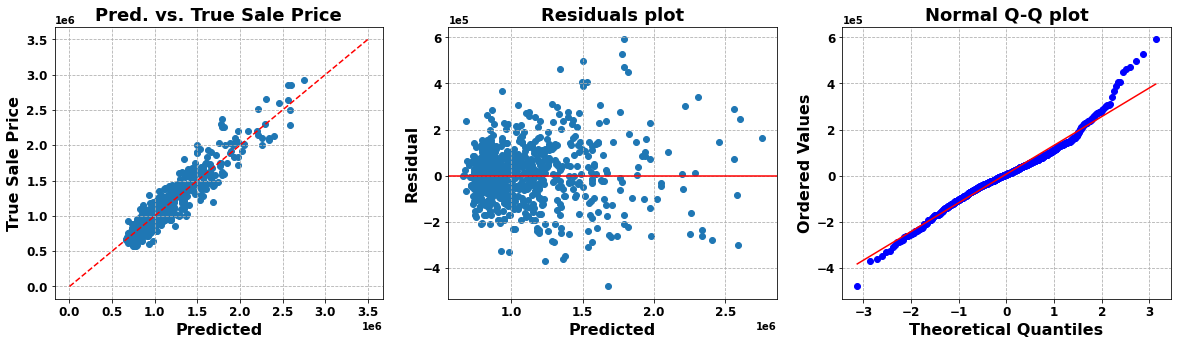

In [469]:
model_4.fit(X4_cv_scaled, y4_cv)

y4_pred = model_4.predict(X4_cv_scaled)

diagnostic_plots(X4_cv_scaled, 10**y4_cv, 10**y4_pred)

### Model 5 - "Lazy" ElasticNet Regression (with just the Lasso-selected variables)

In [421]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X5 = temp_df[['hm_sqft', 'lot_size', 'yr_built', 'schools']]
X5['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X5['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
X5['baths_X_yr_built'] = temp_df['baths'] * temp_df['yr_built']
X5['baths_X_garage'] = temp_df['baths'] * temp_df['garage']
X5['baths_X_one_story'] = temp_df['baths'] * temp_df['one_story']
X5['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X5['baths_X_city_granada_hills'] = temp_df['baths'] * temp_df['city_granada_hills']
X5['baths_X_city_north_hills'] = temp_df['baths'] * temp_df['city_north_hills']
X5['baths_X_city_porter_ranch'] = temp_df['baths'] * temp_df['city_porter_ranch']
X5['baths_X_city_west_hills'] = temp_df['baths'] * temp_df['city_west_hills']
X5['hm_sqft_X_yr_built'] = temp_df['hm_sqft'] * temp_df['yr_built']
X5['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X5['hm_sqft_X_city_chatsworth'] = temp_df['hm_sqft'] * temp_df['city_chatsworth']
X5['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X5['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X5['hm_sqft_X_city_porter_ranch'] = temp_df['hm_sqft'] * temp_df['city_porter_ranch']
X5['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X5['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X5['lot_size_X_garage'] = temp_df['lot_size'] * temp_df['garage']
X5['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X5['lot_size_X_city_chatsworth'] = temp_df['lot_size'] * temp_df['city_chatsworth']
X5['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X5['lot_size_X_city_granada_hills'] = temp_df['lot_size'] * temp_df['city_granada_hills']
X5['lot_size_X_city_north_hills'] = temp_df['lot_size'] * temp_df['city_north_hills']
X5['lot_size_X_city_northridge'] = temp_df['lot_size'] * temp_df['city_northridge']
X5['lot_size_X_city_reseda'] = temp_df['lot_size'] * temp_df['city_reseda']
X5['lot_size_X_city_tarzana'] = temp_df['lot_size'] * temp_df['city_tarzana']
X5['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X5['yr_built_X_city_porter_ranch',] = temp_df['yr_built'] * temp_df['city_porter_ranch']
X5['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X5['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X5['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X5['one_story_X_schools'] = temp_df['one_story'] * temp_df['schools']
X5['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X5['one_story_X_city_chatsworth'] = temp_df['one_story'] * temp_df['city_chatsworth']
X5['one_story_X_city_granada_hills'] = temp_df['one_story'] * temp_df['city_granada_hills']
X5['one_story_X_city_north_hills'] = temp_df['one_story'] * temp_df['city_north_hills']
X5['one_story_X_city_northridge'] = temp_df['one_story'] * temp_df['city_northridge']
X5['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X5['one_story_X_city_west_hills'] = temp_df['one_story'] * temp_df['city_west_hills']
X5['schools_X_city_chatsworth'] = temp_df['schools'] * temp_df['city_chatsworth']
X5['schools_X_city_encino'] = temp_df['schools'] * temp_df['city_encino']
X5['schools_X_city_northridge'] = temp_df['schools'] * temp_df['city_northridge']
X5['schools_X_city_reseda'] = temp_df['schools'] * temp_df['city_reseda']
X5['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X5['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X5['schools_X_city_winnetka'] = temp_df['schools'] * temp_df['city_winnetka']
X5['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X5['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X5['hoa_X_city_porter_ranch'] = temp_df['hoa'] * temp_df['city_porter_ranch']
X5['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X5['beds_SQ'] = temp_df['beds'] * temp_df['beds']
X5['hm_sqft_SQ'] = temp_df['hm_sqft'] * temp_df['hm_sqft']
X5['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/1337528030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X5['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/1337528030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X5['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/1337528030.py:5: SettingWithCopyWar

In [422]:
X5_cv, X5_test, y5_cv, y5_test = train_test_split(X5, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X5_cv_scaled = scaler.fit_transform(X5_cv)

In [93]:
alphas = [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065]
l1_ratios = [0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]

elastic_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=1500000)

elastic_model.fit(X5_cv_scaled, y5_cv)

alpha = round(elastic_model.alpha_, 4)
print('Best alpha = {}'.format(alpha))
l1_ratio = round(elastic_model.l1_ratio_, 2)
print('Best L1 Ratio = {}'.format(l1_ratio))

Best alpha = 0.002
Best L1 Ratio = 0.1


In [423]:
model_5 = ElasticNet(alpha=0.002, l1_ratio=0.1, max_iter=1500000)

cv_rsquareds(X5_cv_scaled, y5_cv, model_5, 5)
cv_maes(X5_cv_scaled, y5_cv, model_5, 5)
cv_rmse(X5_cv_scaled, y5_cv, model_5, 5)

CV R-squareds: [0.862, 0.871, 0.853, 0.81, 0.828]
Mean CV R-squared: 0.845 +/- 0.023

Adjusted CV R-squareds: [0.851, 0.861, 0.841, 0.795, 0.814]
Mean Adjusted CV R-squared: 0.832 +/- 0.024

CV MAEs: [96752, 93732, 99020, 106978, 110503]
Mean CV MAE: 101397 +/- 6325

CV RMSEs: [135410, 125780, 133051, 159930, 151675]
Mean CV RMSE: 141169 +/- 12635


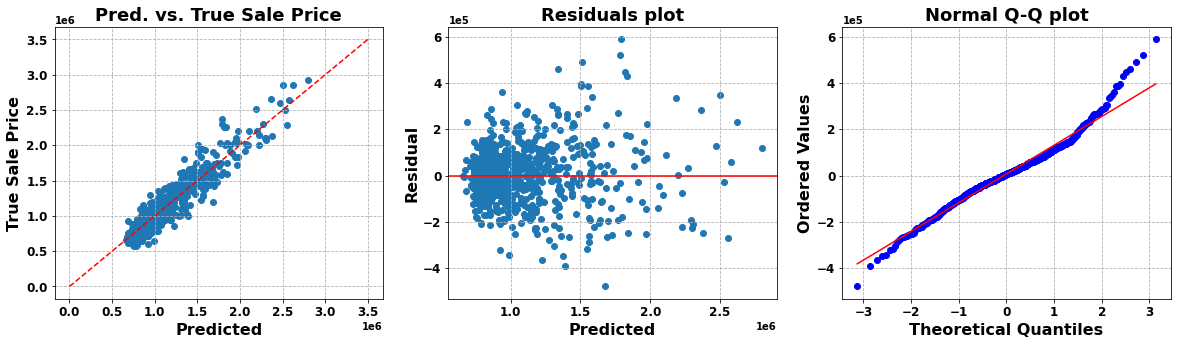

In [424]:
model_5.fit(X5_cv_scaled, y5_cv)

y5_pred = model_5.predict(X5_cv_scaled)

diagnostic_plots(X5_cv_scaled, 10**y5_cv, 10**y5_pred)

Basic Linear Model: Mean CV R-squared = 0.845 +/- 0.023
Basic Linear Model: Mean CV MAE = $101397 +/- $6325
Basic Linear Model: Mean CV RMSE = $141169 +/- $12635


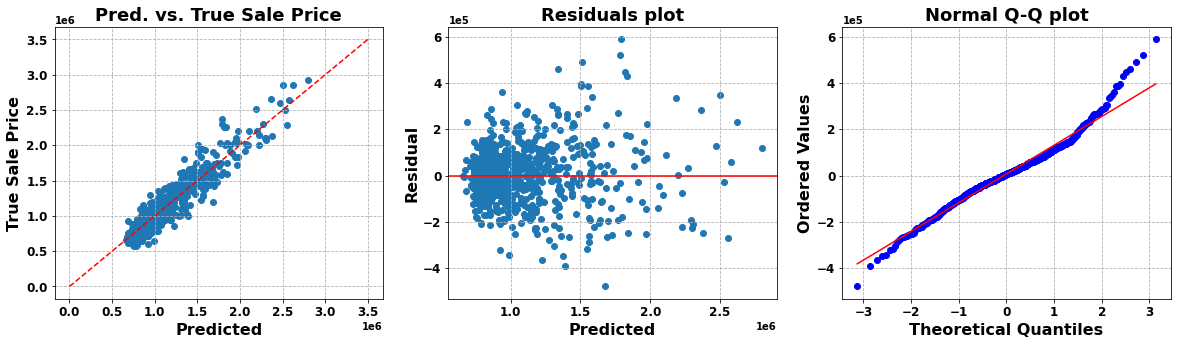

In [431]:
# For final slide deck

scores = cross_val_score(model_5, X5_cv_scaled, y5_cv, scoring='r2', cv=5)
scores = [round(val, 3) for val in scores]
print('Basic Linear Model: Mean CV R-squared = {} +/- {}'
      .format(round(np.mean(scores), 3), round(np.std(scores), 3)))

scores = cross_val_score(model_5, X5_cv_scaled, y5_cv, 
                         scoring=make_scorer(mae_for_log_y, greater_is_better=False), 
                         cv=5)
scores = [round(val) for val in scores]
print('Basic Linear Model: Mean CV MAE = ${} +/- ${}'.format(
    -1*round(np.mean(scores)), round(np.std(scores))))

scores = cross_val_score(model_5, X5_cv_scaled, y5_cv, 
                         scoring=make_scorer(rmse_for_log_y, greater_is_better=False), 
                         cv=5)
scores = [round(val) for val in scores]
print('Basic Linear Model: Mean CV RMSE = ${} +/- ${}'.format(
    -1*round(np.mean(scores)), round(np.std(scores))))

diagnostic_plots(X5_cv_scaled, 10**y5_cv, 10**y5_pred)

In [484]:
var_magnitudes = sorted(list(zip(X4_cv.columns, model_4.coef_)), key=lambda x: np.abs(x[1]), reverse=True)

In [501]:
min_val = 0.01
top_magnitudes = [val for val in var_magnitudes if np.abs(val[1]) >= min_val]
y, x = map(list,zip(*top_magnitudes))
colors = ['Positive' if val >= 0 else 'Negative' for val in x]

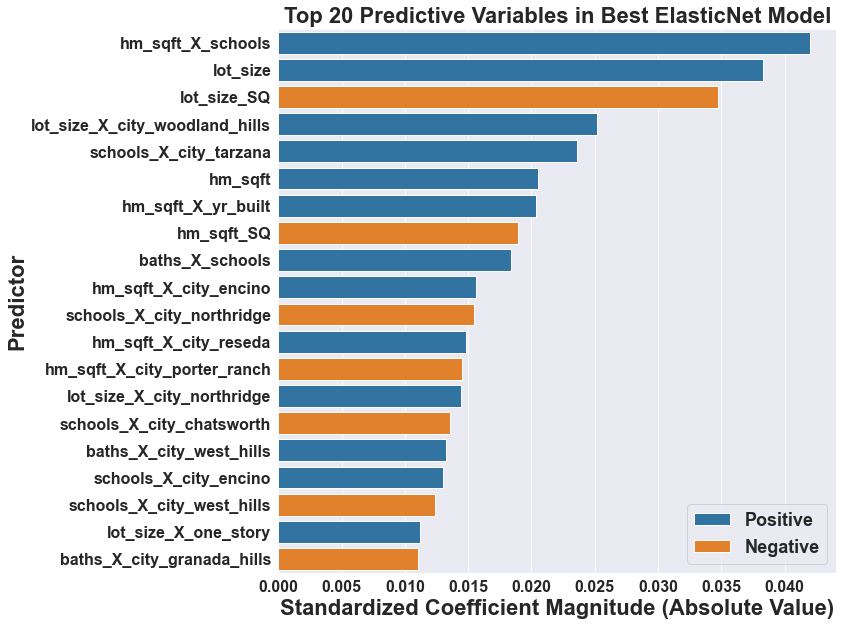

In [518]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')

sns.barplot(x=np.abs(x), y=y, hue=colors, dodge=False)
plt.legend(fontsize=18,
           loc='lower right')
plt.title('Top 20 Predictive Variables in Best ElasticNet Model',
          fontsize=22, fontweight='bold')
plt.xlabel('Standardized Coefficient Magnitude (Absolute Value)',
           fontsize=22, fontweight='bold')
plt.xticks(fontsize=16)
plt.ylabel('Predictor',
           fontsize=22, fontweight='bold')
plt.yticks(fontsize=16, rotation=0);

### Model 6: Random Forest Regression (with just the Lasso-selected variables)

In [434]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X6 = temp_df[['hm_sqft', 'lot_size', 'yr_built', 'schools']]
X6['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X6['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
X6['baths_X_yr_built'] = temp_df['baths'] * temp_df['yr_built']
X6['baths_X_garage'] = temp_df['baths'] * temp_df['garage']
X6['baths_X_one_story'] = temp_df['baths'] * temp_df['one_story']
X6['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X6['baths_X_city_granada_hills'] = temp_df['baths'] * temp_df['city_granada_hills']
X6['baths_X_city_north_hills'] = temp_df['baths'] * temp_df['city_north_hills']
X6['baths_X_city_porter_ranch'] = temp_df['baths'] * temp_df['city_porter_ranch']
X6['baths_X_city_west_hills'] = temp_df['baths'] * temp_df['city_west_hills']
X6['hm_sqft_X_yr_built'] = temp_df['hm_sqft'] * temp_df['yr_built']
X6['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X6['hm_sqft_X_city_chatsworth'] = temp_df['hm_sqft'] * temp_df['city_chatsworth']
X6['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X6['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X6['hm_sqft_X_city_porter_ranch'] = temp_df['hm_sqft'] * temp_df['city_porter_ranch']
X6['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X6['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X6['lot_size_X_garage'] = temp_df['lot_size'] * temp_df['garage']
X6['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X6['lot_size_X_city_chatsworth'] = temp_df['lot_size'] * temp_df['city_chatsworth']
X6['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X6['lot_size_X_city_granada_hills'] = temp_df['lot_size'] * temp_df['city_granada_hills']
X6['lot_size_X_city_north_hills'] = temp_df['lot_size'] * temp_df['city_north_hills']
X6['lot_size_X_city_northridge'] = temp_df['lot_size'] * temp_df['city_northridge']
X6['lot_size_X_city_reseda'] = temp_df['lot_size'] * temp_df['city_reseda']
X6['lot_size_X_city_tarzana'] = temp_df['lot_size'] * temp_df['city_tarzana']
X6['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X6['yr_built_X_city_porter_ranch',] = temp_df['yr_built'] * temp_df['city_porter_ranch']
X6['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X6['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X6['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X6['one_story_X_schools'] = temp_df['one_story'] * temp_df['schools']
X6['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X6['one_story_X_city_chatsworth'] = temp_df['one_story'] * temp_df['city_chatsworth']
X6['one_story_X_city_granada_hills'] = temp_df['one_story'] * temp_df['city_granada_hills']
X6['one_story_X_city_north_hills'] = temp_df['one_story'] * temp_df['city_north_hills']
X6['one_story_X_city_northridge'] = temp_df['one_story'] * temp_df['city_northridge']
X6['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X6['one_story_X_city_west_hills'] = temp_df['one_story'] * temp_df['city_west_hills']
X6['schools_X_city_chatsworth'] = temp_df['schools'] * temp_df['city_chatsworth']
X6['schools_X_city_encino'] = temp_df['schools'] * temp_df['city_encino']
X6['schools_X_city_northridge'] = temp_df['schools'] * temp_df['city_northridge']
X6['schools_X_city_reseda'] = temp_df['schools'] * temp_df['city_reseda']
X6['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X6['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X6['schools_X_city_winnetka'] = temp_df['schools'] * temp_df['city_winnetka']
X6['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X6['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X6['hoa_X_city_porter_ranch'] = temp_df['hoa'] * temp_df['city_porter_ranch']
X6['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X6['beds_SQ'] = temp_df['beds'] * temp_df['beds']
X6['hm_sqft_SQ'] = temp_df['hm_sqft'] * temp_df['hm_sqft']
X6['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/4036107231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X6['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/4036107231.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X6['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/4036107231.py:5: SettingWithCopyWar

In [435]:
X6_cv, X6_test, y6_cv, y6_test = train_test_split(X6, y, test_size=0.2, random_state=42)

In [98]:
grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

model_rf = RandomForestRegressor()

rf_gridsearch = RandomizedSearchCV(estimator = model_rf, 
                                   param_distributions = grid, 
                                   n_iter = 500, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

rf_gridsearch.fit(X6_cv, y6_cv)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='r2')

In [99]:
rf_gridsearch.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': False}

In [100]:
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {'n_estimators': [500, 550, 600, 650, 700],
        'max_features': ['log2'],
        'max_depth': [5, 10, 15],
        'min_samples_split': [3, 4, 5, 6, 7],
        'min_samples_leaf': [1, 2, 3],
        'bootstrap': [False]}

# Perform grid search
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X6_cv, y6_cv)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [5, 10, 15],
                         'max_features': ['log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'n_estimators': [500, 550, 600, 650, 700]})

In [101]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 600}

In [436]:
model_6 = RandomForestRegressor(
    n_estimators=600,
    min_samples_split=6,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=15,
    bootstrap=False
)

cv_rsquareds(X6_cv, y6_cv, model_6, 5)
cv_maes(X6_cv, y6_cv, model_6, 5)
cv_rmse(X6_cv, y6_cv, model_6, 5)

CV R-squareds: [0.841, 0.854, 0.836, 0.76, 0.796]
Mean CV R-squared: 0.817 +/- 0.035

Adjusted CV R-squareds: [0.828, 0.842, 0.823, 0.741, 0.78]
Mean Adjusted CV R-squared: 0.803 +/- 0.037

CV MAEs: [104783, 99052, 104259, 116857, 118354]
Mean CV MAE: 108661 +/- 7588

CV RMSEs: [147255, 134893, 146311, 179251, 170694]
Mean CV RMSE: 155681 +/- 16564


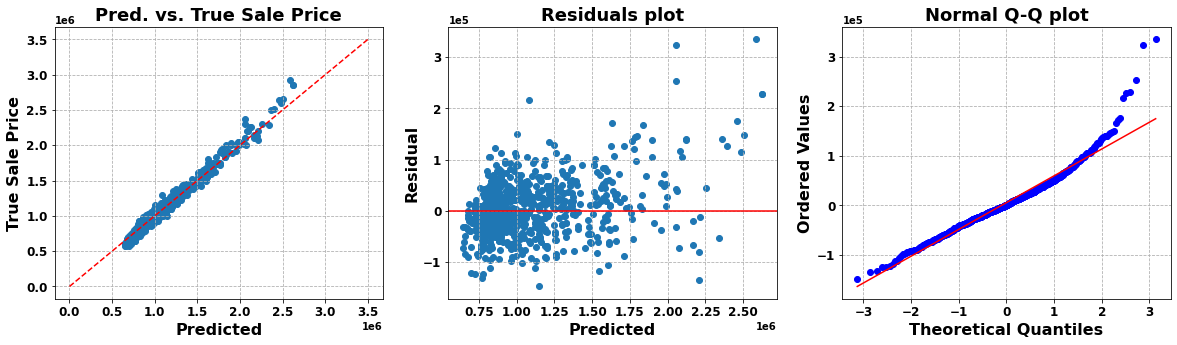

In [437]:
model_6.fit(X6_cv, y6_cv)

y6_pred = model_6.predict(X6_cv)

diagnostic_plots(X6_cv, 10**y6_cv, 10**y6_pred)

### Model 7 - XGBoost (with just the Lasso-selected variables)

In [106]:
temp_df = df_data[(df_data['sold_price'] >= 575000) & (df_data['sold_price'] <= 3e6)]
X7 = temp_df[['hm_sqft', 'lot_size', 'yr_built', 'schools']]
X7['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
X7['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
X7['baths_X_yr_built'] = temp_df['baths'] * temp_df['yr_built']
X7['baths_X_garage'] = temp_df['baths'] * temp_df['garage']
X7['baths_X_one_story'] = temp_df['baths'] * temp_df['one_story']
X7['baths_X_schools'] = temp_df['baths'] * temp_df['schools']
X7['baths_X_city_granada_hills'] = temp_df['baths'] * temp_df['city_granada_hills']
X7['baths_X_city_north_hills'] = temp_df['baths'] * temp_df['city_north_hills']
X7['baths_X_city_porter_ranch'] = temp_df['baths'] * temp_df['city_porter_ranch']
X7['baths_X_city_west_hills'] = temp_df['baths'] * temp_df['city_west_hills']
X7['hm_sqft_X_yr_built'] = temp_df['hm_sqft'] * temp_df['yr_built']
X7['hm_sqft_X_schools'] = temp_df['hm_sqft'] * temp_df['schools']
X7['hm_sqft_X_city_chatsworth'] = temp_df['hm_sqft'] * temp_df['city_chatsworth']
X7['hm_sqft_X_city_encino'] = temp_df['hm_sqft'] * temp_df['city_encino']
X7['hm_sqft_X_city_north_hills'] = temp_df['hm_sqft'] * temp_df['city_north_hills']
X7['hm_sqft_X_city_porter_ranch'] = temp_df['hm_sqft'] * temp_df['city_porter_ranch']
X7['hm_sqft_X_city_reseda'] = temp_df['hm_sqft'] * temp_df['city_reseda']
X7['hm_sqft_X_city_winnetka'] = temp_df['hm_sqft'] * temp_df['city_winnetka']
X7['lot_size_X_garage'] = temp_df['lot_size'] * temp_df['garage']
X7['lot_size_X_one_story'] = temp_df['lot_size'] * temp_df['one_story']
X7['lot_size_X_city_chatsworth'] = temp_df['lot_size'] * temp_df['city_chatsworth']
X7['lot_size_X_city_encino'] = temp_df['lot_size'] * temp_df['city_encino']
X7['lot_size_X_city_granada_hills'] = temp_df['lot_size'] * temp_df['city_granada_hills']
X7['lot_size_X_city_north_hills'] = temp_df['lot_size'] * temp_df['city_north_hills']
X7['lot_size_X_city_northridge'] = temp_df['lot_size'] * temp_df['city_northridge']
X7['lot_size_X_city_reseda'] = temp_df['lot_size'] * temp_df['city_reseda']
X7['lot_size_X_city_tarzana'] = temp_df['lot_size'] * temp_df['city_tarzana']
X7['lot_size_X_city_woodland_hills'] = temp_df['lot_size'] * temp_df['city_woodland_hills']
X7['yr_built_X_city_porter_ranch',] = temp_df['yr_built'] * temp_df['city_porter_ranch']
X7['garage_X_one_story'] = temp_df['garage'] * temp_df['one_story']
X7['garage_X_hoa'] = temp_df['garage'] * temp_df['hoa']
X7['garage_X_city_west_hills'] = temp_df['garage'] * temp_df['city_west_hills']
X7['one_story_X_schools'] = temp_df['one_story'] * temp_df['schools']
X7['one_story_X_hoa'] = temp_df['one_story'] * temp_df['hoa']
X7['one_story_X_city_chatsworth'] = temp_df['one_story'] * temp_df['city_chatsworth']
X7['one_story_X_city_granada_hills'] = temp_df['one_story'] * temp_df['city_granada_hills']
X7['one_story_X_city_north_hills'] = temp_df['one_story'] * temp_df['city_north_hills']
X7['one_story_X_city_northridge'] = temp_df['one_story'] * temp_df['city_northridge']
X7['one_story_X_city_porter_ranch'] = temp_df['one_story'] * temp_df['city_porter_ranch']
X7['one_story_X_city_west_hills'] = temp_df['one_story'] * temp_df['city_west_hills']
X7['schools_X_city_chatsworth'] = temp_df['schools'] * temp_df['city_chatsworth']
X7['schools_X_city_encino'] = temp_df['schools'] * temp_df['city_encino']
X7['schools_X_city_northridge'] = temp_df['schools'] * temp_df['city_northridge']
X7['schools_X_city_reseda'] = temp_df['schools'] * temp_df['city_reseda']
X7['schools_X_city_tarzana'] = temp_df['schools'] * temp_df['city_tarzana']
X7['schools_X_city_west_hills'] = temp_df['schools'] * temp_df['city_west_hills']
X7['schools_X_city_winnetka'] = temp_df['schools'] * temp_df['city_winnetka']
X7['hoa_X_city_chatsworth'] = temp_df['hoa'] * temp_df['city_chatsworth']
X7['hoa_X_city_granada_hills'] = temp_df['hoa'] * temp_df['city_granada_hills']
X7['hoa_X_city_porter_ranch'] = temp_df['hoa'] * temp_df['city_porter_ranch']
X7['hoa_X_city_woodland_hills'] = temp_df['hoa'] * temp_df['city_woodland_hills']
X7['beds_SQ'] = temp_df['beds'] * temp_df['beds']
X7['hm_sqft_SQ'] = temp_df['hm_sqft'] * temp_df['hm_sqft']
X7['lot_size_SQ'] = temp_df['lot_size'] * temp_df['lot_size']

del temp_df

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/787326766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X7['beds_X_city_lake_balboa'] = temp_df['beds'] * temp_df['city_lake_balboa']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/787326766.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X7['beds_X_city_north_hills'] = temp_df['beds'] * temp_df['city_north_hills']
/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_62399/787326766.py:5: SettingWithCopyWarnin

In [107]:
X7_cv, X7_test, y7_cv, y7_test = train_test_split(X7, y, test_size=0.2, random_state=42)

In [108]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 2, 3, 5],
        'subsample': [0.3, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['reg:squarederror', 'reg:pseudohubererror']
}

model_xgb = xgboost.XGBRegressor()

xgb_gridsearch = RandomizedSearchCV(estimator = model_xgb, 
                                   param_distributions = grid, 
                                   n_iter = 200, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

xgb_gridsearch.fit(X7_cv, y7_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [109]:
warnings.filterwarnings(action='ignore', category=UserWarning)
xgb_gridsearch.best_params_

{'subsample': 0.5,
 'objective': 'reg:squarederror',
 'n_estimators': 1000,
 'min_child_weight': 2,
 'max_depth': 5,
 'learning_rate': 0.01,
 'colsample_bytree': 0.3}

In [110]:
warnings.filterwarnings(action='ignore', category=UserWarning)
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {
        'learning_rate': [0.005, 0.01, 0.02, 0.05],
        'max_depth': [4, 5, 6],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.4, 0.5, 0.6],
        'colsample_bytree': [0.2, 0.3, 0.4],
        'n_estimators' : [900, 1000, 1200],
        'objective': ['reg:squarederror']
}

# Perform grid search
grid_search = GridSearchCV(estimator = xgboost.XGBRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X7_cv, y7_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [111]:
warnings.filterwarnings(action='ignore', category=UserWarning)
grid_search.best_params_

{'colsample_bytree': 0.2,
 'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 1200,
 'objective': 'reg:squarederror',
 'subsample': 0.6}

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

In [282]:
#### Need this to filter annoying warnings (known bug/'feature' of XGBoost)
warnings.filterwarnings(action='ignore', category=UserWarning)

# model_xgb = xgboost.XGBRegressor(objective='reg:pseudohubererror', random_state=42)
model_7 = xgboost.XGBRegressor(
        subsample=0.6,
        objective='reg:squarederror',
        n_estimators=1200,
        min_child_weight=3,
        max_depth=4,
        learning_rate=0.01,
        colsample_bytree=0.2
)

cv_rsquareds(X7_cv, y7_cv, model_7, 5)
cv_maes(X7_cv, y7_cv, model_7, 5)
cv_rmse(X7_cv, y7_cv, model_7, 5)

CV R-squareds: [0.854, 0.876, 0.837, 0.795, 0.797]
Mean CV R-squared: 0.832 +/- 0.032

Adjusted CV R-squareds: [0.842, 0.866, 0.824, 0.779, 0.781]
Mean Adjusted CV R-squared: 0.818 +/- 0.034

CV MAEs: [101687, 90092, 104616, 108949, 120338]
Mean CV MAE: 105136 +/- 9840

CV RMSEs: [143081, 122772, 145149, 164000, 167966]
Mean CV RMSE: 148594 +/- 16258


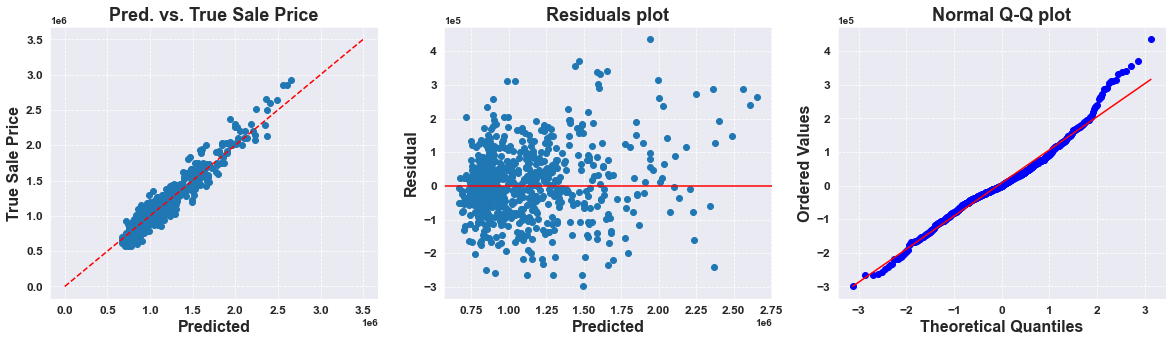

In [572]:
model_7.fit(X7_cv, y7_cv)

y7_pred = model_7.predict(X7_cv)

diagnostic_plots(X7_cv, 10**y7_cv, 10**y7_pred)

In [573]:
model_7.get_booster().get_score(importance_type="gain")

{'hm_sqft_SQ': 0.040998914320710976,
 'hm_sqft': 0.02555464045932466,
 'hm_sqft_X_yr_built': 0.027556111456250105,
 'hm_sqft_X_schools': 0.07393325320611907,
 'baths_X_schools': 0.045905901355260834,
 'lot_size_SQ': 0.04430960921724119,
 'lot_size': 0.03232576374164707,
 'baths_X_yr_built': 0.014779044684885868,
 'lot_size_X_one_story': 0.0153298815188535,
 'baths_X_one_story': 0.011524656396114184,
 'lot_size_X_city_woodland_hills': 0.022272491364191453,
 'hm_sqft_X_city_encino': 0.03315931624469357,
 'hm_sqft_X_city_north_hills': 0.011770915962914278,
 'schools': 0.018157299762835918,
 'baths_X_city_north_hills': 0.015460333276874997,
 'lot_size_X_city_encino': 0.026910559779994434,
 'lot_size_X_city_north_hills': 0.00815703387455,
 'schools_X_city_encino': 0.0294520842880763,
 'one_story_X_city_north_hills': 0.014580752226250002,
 'schools_X_city_tarzana': 0.0290988252035,
 'beds_X_city_north_hills': 0.012176541207820515,
 'one_story_X_city_granada_hills': 0.00717205745473077,
 'lot

In [588]:
m7_importance = model_7.get_booster().get_score(importance_type="gain")

# Some kind of strange error led to this one key having the tuple included in the key name
m7_importance['yr_built_X_city_porter_ranch'] = m7_importance.pop('(yr_built_X_city_porter_ranch,)')

m7_importance = dict(sorted(m7_importance.items(), key=lambda item: item[1], reverse=True))

m7_importance.keys()

dict_keys(['hm_sqft_X_schools', 'baths_X_schools', 'lot_size_SQ', 'hm_sqft_SQ', 'hm_sqft_X_city_encino', 'lot_size', 'schools_X_city_encino', 'schools_X_city_tarzana', 'hm_sqft_X_yr_built', 'lot_size_X_city_encino', 'hm_sqft', 'lot_size_X_city_woodland_hills', 'lot_size_X_city_tarzana', 'schools', 'baths_X_city_north_hills', 'lot_size_X_one_story', 'baths_X_yr_built', 'one_story_X_city_north_hills', 'baths_X_city_west_hills', 'beds_X_city_north_hills', 'hm_sqft_X_city_north_hills', 'baths_X_one_story', 'one_story_X_schools', 'lot_size_X_city_granada_hills', 'schools_X_city_northridge', 'one_story_X_city_west_hills', 'baths_X_city_granada_hills', 'hm_sqft_X_city_porter_ranch', 'schools_X_city_chatsworth', 'one_story_X_city_porter_ranch', 'schools_X_city_winnetka', 'schools_X_city_west_hills', 'baths_X_city_porter_ranch', 'hm_sqft_X_city_chatsworth', 'lot_size_X_city_chatsworth', 'lot_size_X_city_north_hills', 'garage_X_city_west_hills', 'hm_sqft_X_city_winnetka', 'one_story_X_city_grana

In [594]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')

sns.barplot(x=np.abs(x), y=y, hue=colors, dodge=False)
plt.legend(fontsize=18,
           loc='lower right')
plt.title('Top 20 Predictive Variables in Best ElasticNet Model',
          fontsize=22, fontweight='bold')
plt.xlabel('Standardized Coefficient Magnitude (Absolute Value)',
           fontsize=22, fontweight='bold')
plt.xticks(fontsize=16)
plt.ylabel('Predictor',
           fontsize=22, fontweight='bold')
plt.yticks(fontsize=16, rotation=0);

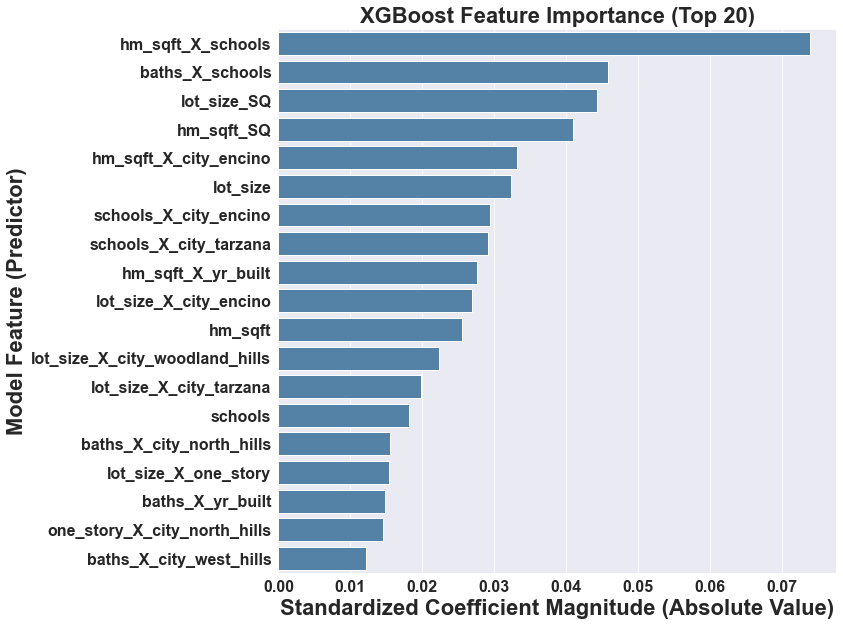

In [597]:
plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
# plt.barh(list(m7_importance.keys())[0:19], list(m7_importance.values())[0:19])
sns.barplot(y=list(m7_importance.keys())[0:19], x=list(m7_importance.values())[0:19], 
            dodge=False, color='steelblue')
plt.title('XGBoost Feature Importance (Top 20)',
          fontsize=22, fontweight='bold')
plt.xlabel('Standardized Coefficient Magnitude (Absolute Value)',
           fontsize=22, fontweight='bold')
plt.xticks(fontsize=16)
plt.ylabel('Model Feature (Predictor)',
           fontsize=22, fontweight='bold')
plt.yticks(fontsize=16, rotation=0);

In [576]:
list(m7_importance.keys())[0:19]

['one_story_X_hoa',
 'beds_X_city_lake_balboa',
 'hoa_X_city_woodland_hills',
 'yr_built',
 'schools_X_city_reseda',
 'one_story_X_city_northridge',
 'lot_size_X_city_reseda',
 'lot_size_X_garage',
 '(yr_built_X_city_porter_ranch,)',
 'beds_SQ',
 'lot_size_X_city_northridge',
 'baths_X_garage',
 'one_story_X_city_chatsworth',
 'hm_sqft_X_city_reseda',
 'garage_X_one_story',
 'one_story_X_city_granada_hills',
 'hm_sqft_X_city_winnetka',
 'garage_X_city_west_hills',
 'lot_size_X_city_north_hills']

In [379]:
feature_importances = sorted(list(zip(X7_cv.columns, model_7.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances

[('hm_sqft_SQ', 0.09629262),
 ('hm_sqft', 0.08597524),
 ('city_woodland_hills', 0.07905286),
 ('city_encino', 0.07402835),
 ('lot_size_SQ', 0.06409634),
 ('baths', 0.0588364),
 ('lot_size', 0.05262431),
 ('city_tarzana', 0.04924658),
 ('schools', 0.04480219),
 ('schools_SQ', 0.03850805),
 ('baths_SQ', 0.03409343),
 ('city_north_hills', 0.030629845),
 ('city_granada_hills', 0.026851995),
 ('city_chatsworth', 0.0228371),
 ('city_winnetka', 0.022812579),
 ('city_west_hills', 0.021928111),
 ('city_lake_balboa', 0.02131224),
 ('one_story', 0.02101929),
 ('beds_SQ', 0.020374412),
 ('city_reseda', 0.019870147),
 ('yr_built', 0.018897373),
 ('city_porter_ranch', 0.018774195),
 ('yr_built_SQ', 0.016911658),
 ('city_northridge', 0.016837988),
 ('beds', 0.016274095),
 ('garage', 0.015911037),
 ('hoa', 0.011201502)]

# 4) The Winner(s)

## 4a) Model 5 (ElasticNet) is the Very Best: Time to find Test Set performance

In [439]:
X5_test_scaled.shape

(198, 58)

In [440]:
y5_test_pred.shape

(198,)

Best Linear Model (ElasticNet): Mean CV R-squared = 0.845 +/- 0.023; Test Set R-Squared = 0.82
Best Linear Model (ElasticNet): Mean CV MAE = $101397 +/- $6325;  Test Set MAE = $112550
Best Linear Model (ElasticNet): Mean CV RMSE = $141169 +/- $12635; Test Set RMSE = $177272


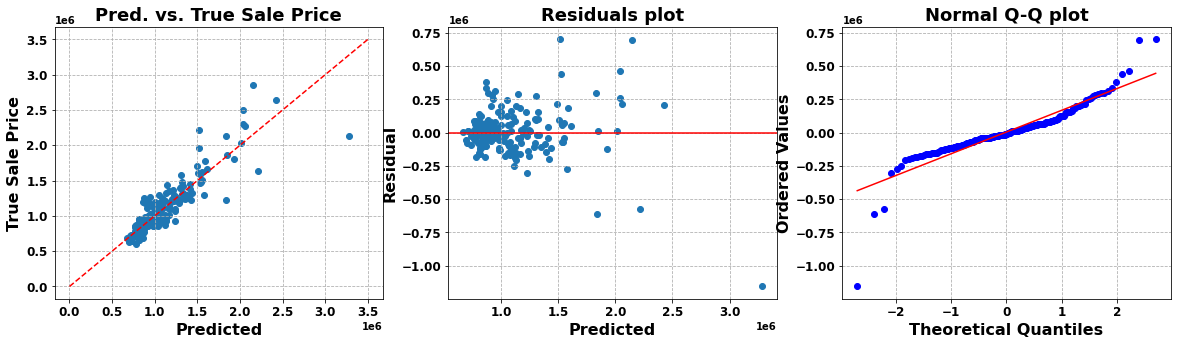

In [441]:
X5_test_scaled = scaler.fit_transform(X5_test)
y5_test_pred = model_5.predict(X5_test_scaled)

scores = cross_val_score(model_5, X5_cv_scaled, y5_cv, scoring='r2', cv=5)
scores = [round(val, 3) for val in scores]
r_squared = r2_score(y5_test, y5_test_pred)
print('Best Linear Model (ElasticNet): Mean CV R-squared = {} +/- {}; Test Set R-Squared = {}'
      .format(round(np.mean(scores), 3), round(np.std(scores), 3), round(r_squared, 3)))

scores = cross_val_score(model_5, X5_cv_scaled, y5_cv, 
                         scoring=make_scorer(mae_for_log_y, greater_is_better=False), 
                         cv=5)
scores = [round(val) for val in scores]
mae = mae_for_log_y(y5_test, y5_test_pred)
print('Best Linear Model (ElasticNet): Mean CV MAE = ${} +/- ${};  Test Set MAE = ${}'.format(
    -1*round(np.mean(scores)), round(np.std(scores)), round(mae)))

scores = cross_val_score(model_5, X5_cv_scaled, y5_cv, 
                         scoring=make_scorer(rmse_for_log_y, greater_is_better=False), 
                         cv=5)
scores = [round(val) for val in scores]
rmse = rmse_for_log_y(y5_test, y5_test_pred)
print('Best Linear Model (ElasticNet): Mean CV RMSE = ${} +/- ${}; Test Set RMSE = ${}'.format(
    -1*round(np.mean(scores)), round(np.std(scores)), round(rmse)))

diagnostic_plots(X5_test_scaled, 10**y5_test, 10**y5_test_pred)

Best Linear Model (ElasticNet): Test Set R-Squared = 0.82
Best Linear Model (ElasticNet): Test Set MAE = $112550
Best Linear Model (ElasticNet): Test Set RMSE = $177272


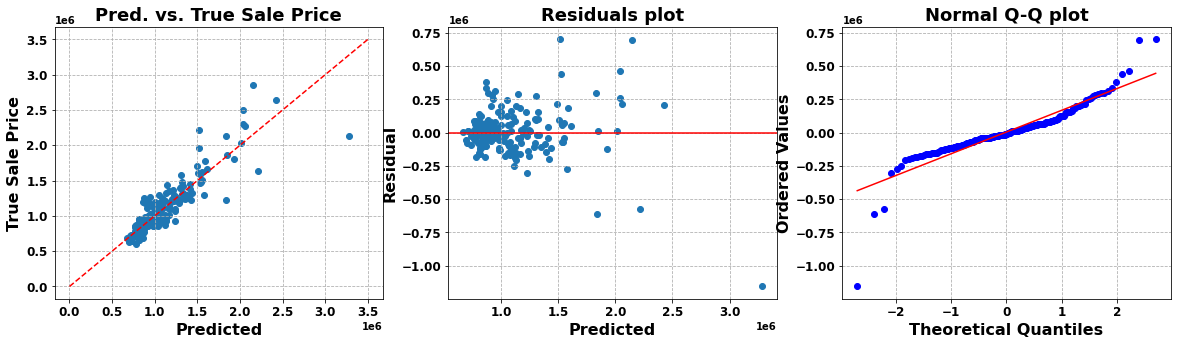

In [445]:
X5_test_scaled = scaler.fit_transform(X5_test)
y5_test_pred = model_5.predict(X5_test_scaled)

r_squared = r2_score(y5_test, y5_test_pred)
print('Best Linear Model (ElasticNet): Test Set R-Squared = {}'.format(round(r_squared, 3)))

mae = mae_for_log_y(y5_test, y5_test_pred)
print('Best Linear Model (ElasticNet): Test Set MAE = ${}'.format(round(mae)))

rmse = rmse_for_log_y(y5_test, y5_test_pred)
print('Best Linear Model (ElasticNet): Test Set RMSE = ${}'.format(round(rmse)))

diagnostic_plots(X5_test_scaled, 10**y5_test, 10**y5_test_pred)

## 4b) Model 6 (RandomForest) Test Set performance

RandomForest: Mean CV R-squared = 0.818 +/- 0.035; Test Set R-Squared = 0.806
RandomForest: Mean CV MAE = $109312 +/- $8352;  Test Set MAE = $113709
RandomForest: Mean CV RMSE = $155945 +/- $16837; Test Set RMSE = $174812


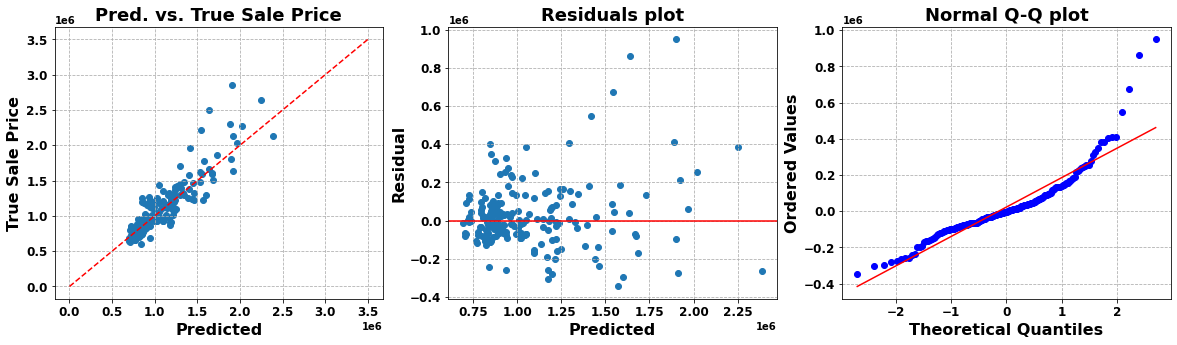

In [442]:
y6_test_pred = model_6.predict(X6_test)

scores = cross_val_score(model_6, X6_cv, y6_cv, scoring='r2', cv=5)
scores = [round(val, 3) for val in scores]
r_squared = r2_score(y6_test, y6_test_pred)
print('RandomForest: Mean CV R-squared = {} +/- {}; Test Set R-Squared = {}'
      .format(round(np.mean(scores), 3), round(np.std(scores), 3), round(r_squared, 3)))

scores = cross_val_score(model_6, X6_cv, y6_cv, 
                         scoring=make_scorer(mae_for_log_y, greater_is_better=False), 
                         cv=5)
scores = [round(val) for val in scores]
mae = mae_for_log_y(y6_test, y6_test_pred)
print('RandomForest: Mean CV MAE = ${} +/- ${};  Test Set MAE = ${}'.format(
    -1*round(np.mean(scores)), round(np.std(scores)), round(mae)))

scores = cross_val_score(model_6, X6_cv, y6_cv, 
                         scoring=make_scorer(rmse_for_log_y, greater_is_better=False), 
                         cv=5)
scores = [round(val) for val in scores]
rmse = rmse_for_log_y(y6_test, y6_test_pred)
print('RandomForest: Mean CV RMSE = ${} +/- ${}; Test Set RMSE = ${}'.format(
    -1*round(np.mean(scores)), round(np.std(scores)), round(rmse)))

diagnostic_plots(X6_test, 10**y6_test, 10**y6_test_pred)

## 4c) Model 7 (XGBoost Regressor) Test Set performance

XGBoost: Mean CV R-squared = 0.832 +/- 0.032; Test Set R-Squared = 0.82
XGBoost: Mean CV MAE = $105136 +/- $9840;  Test Set MAE = $111591
XGBoost: Mean CV RMSE = $148594 +/- $16258; Test Set RMSE = $163912


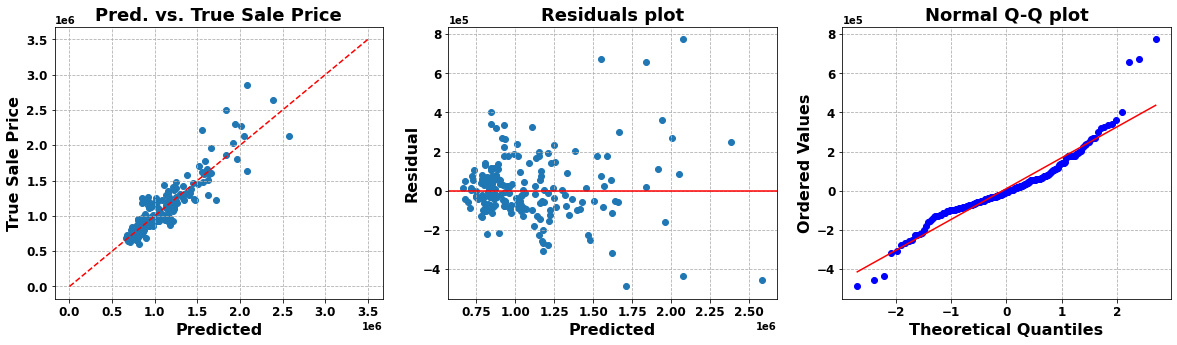

In [443]:
y7_test_pred = model_7.predict(X7_test)

scores = cross_val_score(model_7, X7_cv, y7_cv, scoring='r2', cv=5)
scores = [round(val, 3) for val in scores]
r_squared = r2_score(y7_test, y7_test_pred)
print('XGBoost: Mean CV R-squared = {} +/- {}; Test Set R-Squared = {}'
      .format(round(np.mean(scores), 3), round(np.std(scores), 3), round(r_squared, 3)))

scores = cross_val_score(model_7, X7_cv, y7_cv, 
                         scoring=make_scorer(mae_for_log_y, greater_is_better=False), 
                         cv=5)
scores = [round(val) for val in scores]
mae = mae_for_log_y(y7_test, y7_test_pred)
print('XGBoost: Mean CV MAE = ${} +/- ${};  Test Set MAE = ${}'.format(
    -1*round(np.mean(scores)), round(np.std(scores)), round(mae)))

scores = cross_val_score(model_7, X7_cv, y7_cv, 
                         scoring=make_scorer(rmse_for_log_y, greater_is_better=False), 
                         cv=5)
scores = [round(val) for val in scores]
rmse = rmse_for_log_y(y7_test, y7_test_pred)
print('XGBoost: Mean CV RMSE = ${} +/- ${}; Test Set RMSE = ${}'.format(
    -1*round(np.mean(scores)), round(np.std(scores)), round(rmse)))

diagnostic_plots(X7_test, 10**y7_test, 10**y7_test_pred)